In [ ]:
!unzip datasetik_of_mine.zip

In [ ]:
!unzip lfw.zip

Показано результат, скорочений до останніх рядків (5000).
  inflating: lfw/Pak_Gil_Yon/Pak_Gil_Yon_0001.jpg  
   creating: lfw/Pamela_Anderson/
  inflating: lfw/Pamela_Anderson/Pamela_Anderson_0001.jpg  
  inflating: lfw/Pamela_Anderson/Pamela_Anderson_0002.jpg  
  inflating: lfw/Pamela_Anderson/Pamela_Anderson_0003.jpg  
  inflating: lfw/Pamela_Anderson/Pamela_Anderson_0004.jpg  
  inflating: lfw/Pamela_Anderson/Pamela_Anderson_0005.jpg  
   creating: lfw/Pamela_Melroy/
  inflating: lfw/Pamela_Melroy/Pamela_Melroy_0001.jpg  
   creating: lfw/Paola_Espinoza/
  inflating: lfw/Paola_Espinoza/Paola_Espinoza_0001.jpg  
   creating: lfw/Paradorn_Srichaphan/
  inflating: lfw/Paradorn_Srichaphan/Paradorn_Srichaphan_0001.jpg  
  inflating: lfw/Paradorn_Srichaphan/Paradorn_Srichaphan_0002.jpg  
  inflating: lfw/Paradorn_Srichaphan/Paradorn_Srichaphan_0003.jpg  
  inflating: lfw/Paradorn_Srichaphan/Paradorn_Srichaphan_0004.jpg  
  inflating: lfw/Paradorn_Srichaphan/Paradorn_Srichaphan_0005.jpg  

In [ ]:
!pip install insightface

In [ ]:
# @title Підрахунок датасету
import os
from pathlib import Path
import numpy as np

def analyze_lfw_original(dataset_dir="/content/lfw"):
    path = Path(dataset_dir)

    if not path.exists():
        print(f"❌ Папка {dataset_dir} не знайдена!")
        return

    print(f"📊 АНАЛІЗ ОРИГІНАЛЬНОГО ДАТАСЕТУ: {dataset_dir}")
    print("=" * 50)

    people_folders = [f for f in path.iterdir() if f.is_dir()]
    total_people = len(people_folders)

    if total_people == 0:
        print("Папка пуста або не містить підпапок з людьми.")
        return

    images_counts = []
    total_images = 0

    # Розширення файлів, які шукаємо
    valid_exts = {'.jpg', '.jpeg', '.png'}

    # Проходимо по кожній людині
    for person_folder in people_folders:
        # Рахуємо картинки в папці людини
        imgs = [f for f in person_folder.iterdir() if f.suffix.lower() in valid_exts]
        count = len(imgs)

        if count > 0:
            images_counts.append(count)
            total_images += count

    # Перетворюємо в numpy масив для легкої статистики
    counts = np.array(images_counts)

    print(f"👥 Всього людей (папок):      {total_people}")
    print(f"🖼️  Всього зображень:         {total_images}")
    print("-" * 50)

    if len(counts) > 0:
        print(f"📉 Мінімум фото на людину:   {counts.min()}")
        print(f"📈 Максимум фото на людину:  {counts.max()}")
        print(f"📊 Середнє фото на людину:   {counts.mean():.2f}")
        print(f"💰 Медіана (більшість має):  {int(np.median(counts))}")

        # Додатково: скільки людей мають лише 1 фото?
        one_shot = np.sum(counts == 1)
        print("-" * 50)
        print(f"⚠️ Людей лише з 1 фото:      {one_shot} (це {(one_shot/total_people)*100:.1f}% від усіх)")
        print(f"✅ Людей з >= 5 фото:        {np.sum(counts >= 5)}")

# --- ЗАПУСК ---
# Перевірте, чи шлях правильний. Зазвичай це /content/lfw
analyze_lfw_original("/content/lfw")

📊 АНАЛІЗ ОРИГІНАЛЬНОГО ДАТАСЕТУ: /content/lfw
👥 Всього людей (папок):      5750
🖼️  Всього зображень:         13255
--------------------------------------------------
📉 Мінімум фото на людину:   1
📈 Максимум фото на людину:  530
📊 Середнє фото на людину:   2.31
💰 Медіана (більшість має):  1
--------------------------------------------------
⚠️ Людей лише з 1 фото:      4069 (це 70.8% від усіх)
✅ Людей з >= 5 фото:        425


In [ ]:
# @title Завантаження та поділ датасету
import os
import shutil
import random
import numpy as np
from pathlib import Path
from PIL import Image
from sklearn.datasets import fetch_lfw_people
from tqdm import tqdm


def download_and_save_lfw_sklearn(dest_dir="/content/lfw_original"):
    """
    Використовує sklearn для завантаження, а потім зберігає картинки як файли.
    Це обходить проблему з прямим скачуванням архіву.
    """
    if os.path.exists(dest_dir) and len(os.listdir(dest_dir)) > 10:
        print(f"Дані вже існують у {dest_dir}.")
        return dest_dir

    print("Завантаження LFW через sklearn...")
    try:
        # Завантажуємо оригінальні зображення (кольорові, без ресайзу)
        lfw = fetch_lfw_people(
            min_faces_per_person=1, # Беремо всіх
            resize=None,            # Оригінальний розмір
            color=True,             # Кольорові
            slice_=None,            # Без обрізки (повне фото)
            download_if_missing=True
        )
    except Exception as e:
        print(f"Критична помилка sklearn: {e}")
        return None

    print(f"Завантажено {len(lfw.images)} зображень. Зберігаємо на диск...")

    # Створюємо структуру папок
    dest_path = Path(dest_dir)
    if dest_path.exists(): shutil.rmtree(dest_path)
    dest_path.mkdir(parents=True)

    # Проходимо по всіх фото і зберігаємо їх
    for idx, (image, target) in enumerate(zip(lfw.images, lfw.target)):
        person_name = lfw.target_names[target].replace(' ', '_') # Ім'я людини

        # Папка для конкретної людини
        person_dir = dest_path / person_name
        person_dir.mkdir(exist_ok=True)

        # Конвертація з формату sklearn (float 0-1) у формат картинки (uint8 0-255)
        if image.max() <= 1.0:
            image = (image * 255).astype(np.uint8)
        else:
            image = image.astype(np.uint8)

        img_pil = Image.fromarray(image)

        # Зберігаємо файл
        save_path = person_dir / f"{person_name}_{idx:04d}.jpg"
        img_pil.save(save_path)

    print(f"Успішно збережено в {dest_dir}")
    return dest_dir


def split_lfw_custom_mixed(source_dir, output_dir, split_ratio=0.8, min_count_fixed=5):
    source_path = Path(source_dir)
    dest_path = Path(output_dir)

    if dest_path.exists(): shutil.rmtree(dest_path)
    (dest_path / "train").mkdir(parents=True)
    (dest_path / "test").mkdir(parents=True)

    print(f"Починаємо розподіл: {source_dir} -> {output_dir}")

    people_folders = [f for f in source_path.iterdir() if f.is_dir()]
    total_stats = {"train": 0, "test": 0}

    for person_folder in tqdm(people_folders, desc="Сортування"):
        person_name = person_folder.name
        images = [f for f in person_folder.iterdir() if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

        if not images: continue

        random.shuffle(images)
        count = len(images)
        train_imgs, test_imgs = [], []

        # ЛОГІКА:
        if count >= min_count_fixed:
            # >= 5 фото: 80% Train / 20% Test
            split_idx = int(count * split_ratio)
            if split_idx == 0 and count > 0: split_idx = 1 # Страховка
            train_imgs = images[:split_idx]
            test_imgs = images[split_idx:]
        else:
            # < 5 фото: < шанс потрапити в train
            for img in images:
                if random.random() < split_ratio:
                    train_imgs.append(img)
                else:
                    test_imgs.append(img)

        # КОПІЮВАННЯ ФАЙЛІВ
        def copy_list(file_list, target_base):
            if not file_list: return
            target_folder = target_base / person_name
            target_folder.mkdir(exist_ok=True)
            for img_path in file_list:
                shutil.copy2(img_path, target_folder / img_path.name)

        copy_list(train_imgs, dest_path / "train")
        copy_list(test_imgs, dest_path / "test")

        total_stats["train"] += len(train_imgs)
        total_stats["test"] += len(test_imgs)

    print(f"\nГОТОВО! Датасет підготовлено.")
    print(f"Train images: {total_stats['train']}")
    print(f"Test images:  {total_stats['test']}")
    print(f"Папка для з датасетом: {output_dir}")


# 1. Завантажуємо та відновлюємо файли
# raw_data_path = download_and_save_lfw_sklearn()

# 2. ділимо на train/test
split_lfw_custom_mixed(
        source_dir="lfw",
        output_dir="/content/lfw_80-20"
    )

Починаємо розподіл: lfw -> /content/lfw_80-20


Сортування: 100%|██████████| 5750/5750 [00:02<00:00, 2522.37it/s]


ГОТОВО! Датасет підготовлено.
Train images: 10447
Test images:  2808
Папка для з датасетом: /content/lfw_80-20


In [ ]:
import shutil
import os
from datetime import datetime
from pathlib import Path

def archive_dataset(source_dir, archive_name=None):

    source_path = Path(source_dir)

    # Перевірка, чи існує папка
    if not source_path.exists():
        print(f"Помилка: Папка {source_dir} не знайдена!")
        return None

    # Генеруємо назву архіву, якщо не вказана
    if archive_name is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M")
        archive_name = f"lfw_dataset_{timestamp}"

    archive_name = archive_name.replace('.zip', '')
    output_path = f"/content/{archive_name}"

    print(f"Починаємо архівування...")
    print(f"   Джерело: {source_dir}")

    # Створюємо ZIP
    # root_dir - це папка, вміст якої ми хочемо запхати в архів
    shutil.make_archive(output_path, 'zip', source_path)

    final_zip_path = output_path + ".zip"

    # Збираємо статистику для звіту
    file_size_mb = os.path.getsize(final_zip_path) / (1024 * 1024)

    # Швидкий підрахунок файлів всередині (для info)
    train_count = len(list((source_path / "train").rglob("*.*")))
    test_count = len(list((source_path / "test").rglob("*.*")))

    print(f"\nАрхів успішно створено!")
    print(f"   Шлях: {final_zip_path}")
    print(f"   Розмір: {file_size_mb:.2f} MB")
    print(f"   Вміст: ~{train_count} train, ~{test_count} test зображень")

    return final_zip_path

dataset_folder = "/content/lfw_80-20"

# Запускаємо архівування
zip_file = archive_dataset(dataset_folder, archive_name="lfw_80-20")

Починаємо архівування...
   Джерело: /content/lfw_80-20

Архів успішно створено!
   Шлях: /content/lfw_80-20.zip
   Розмір: 180.64 MB
   Вміст: ~10447 train, ~2808 test зображень
------------------------------
ЯК ЗАВАНТАЖИТИ:
1. Відкрийте папку 'Files' зліва.
2. Знайдіть файл: lfw_80-20.zip
3. Натисніть три крапки (⋮) -> Download


In [ ]:
# @title Встановлення залежностей
!pip install -q timm torch torchvision pillow tqdm scikit-learn seaborn pandas matplotlib retina-face ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 14.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 126.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 115.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 12.5 MB/s eta 

In [ ]:
# @title Імппорти

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
import timm
from tqdm import tqdm
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
import pandas as pd

In [ ]:
# @title Клас FaceRecognitionViT

class FaceRecognitionViT:
    def __init__(self, model_name='vit_base_patch16_224', detector='retinaface', device='cuda'):
        """
        Face Recognition на базі Vision Transformer (Google ViT)

        Args:
            model_name: 'vit_base_patch16_224', 'vit_large_patch16_224'
            detector: 'retinaface', 'ssd', 'scrfd', 'mtcnn', 'yolov8', 'mediapipe', 'opencv'
            device: 'cuda' або 'cpu'
        """
        print(f"Ініціалізація Vision Transformer ({model_name})...")

        self.device = torch.device(device if torch.cuda.is_available() else 'cpu')
        print(f"Використовується: {self.device}")

        # Завантажити pretrained ViT
        self.model = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.model = self.model.to(self.device)
        self.model.eval()

        # Ініціалізувати детектор
        self.detector_name = detector
        self._init_detector(detector)

        # Transform для ViT
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

        self.database = {}
        self.person_to_id = {}
        self.id_to_person = {}

        print("Vision Transformer готовий!")

    def _init_detector(self, detector):
        """Ініціалізувати обраний детектор"""
        print(f"Ініціалізація детектора: {detector}...")

        if detector == 'retinaface':
            try:
                from retinaface import RetinaFace
                self.face_detector = RetinaFace
                self.detector_type = 'retinaface'
                print("Детектор: RetinaFace")
            except ImportError:
                print("RetinaFace не встановлено. Встановіть: pip install retina-face")

        elif detector == 'ssd':
            try:
                # Завантажити SSD MobileNet для face detection
                modelFile = "res10_300x300_ssd_iter_140000.caffemodel"
                configFile = "deploy.prototxt.txt"

                # Перевірити чи є файли
                if not os.path.exists(modelFile):
                    print("Завантаження SSD моделі...")
                    import urllib.request
                    urllib.request.urlretrieve(
                        "https://github.com/opencv/opencv_3rdparty/raw/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel",
                        modelFile
                    )
                if not os.path.exists(configFile):
                    urllib.request.urlretrieve(
                        "https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt",
                        configFile
                    )

                self.face_detector = cv2.dnn.readNetFromCaffe(configFile, modelFile)
                self.detector_type = 'ssd'
                print("Детектор: SSD MobileNet")
            except Exception as e:
                print(f"SSD не вдалось завантажити: {e}")

        elif detector == 'default(scrfd)':
            try:
                from insightface.app import FaceAnalysis
                self.face_detector = FaceAnalysis(name='buffalo_sc')
                self.face_detector.prepare(ctx_id=0 if torch.cuda.is_available() else -1, det_size=(640, 640))
                self.detector_type = 'scrfd'
                print("Детектор: SCRFD (InsightFace)")
            except ImportError:
                print("InsightFace не встановлено. Встановіть: pip install insightface")

        elif detector == 'mtcnn':
            try:
                from facenet_pytorch import MTCNN
                self.face_detector = MTCNN(
                    image_size=224,
                    margin=20,
                    device=self.device,
                    post_process=False
                )
                self.detector_type = 'mtcnn'
                print("Детектор: MTCNN")
            except ImportError:
                print("MTCNN не встановлено. Встановіть: pip install facenet-pytorch")

        elif detector == 'yolov12':
            try:
                from ultralytics import YOLO
                import os
                import urllib.request

                model_path = 'yolov12m-face.pt'

                # Перевірити чи модель вже завантажена
                if not os.path.exists(model_path):
                    print("YOLOv12m-face не знайдено. Завантаження...")

                    # URL до моделі з GitHub releases
                    model_url = 'https://github.com/YapaLab/yolo-face/releases/download/v1.0/yolov12m-face.pt'

                    try:
                        # Завантажити з progress bar
                        def download_progress(block_num, block_size, total_size):
                            downloaded = block_num * block_size
                            percent = min(downloaded * 100 / total_size, 100)
                            print(f"\rЗавантаження: {percent:.1f}% ({downloaded/1024/1024:.1f}MB / {total_size/1024/1024:.1f}MB)", end='')

                        urllib.request.urlretrieve(model_url, model_path, download_progress)
                        print("\nYOLOv12m-face завантажено")

                    except Exception as e:
                        print(f"\nПомилка завантаження з GitHub: {e}")
                        print("Спроба альтернативного джерела...")

                        # Альтернативний URL (якщо основний не працює)
                        alt_url = 'https://huggingface.co/Bingsu/yolov12m-face/resolve/main/yolov12m-face.pt'

                        try:
                            urllib.request.urlretrieve(alt_url, model_path, download_progress)
                            print("\nYOLOv12m-face завантажено (альтернативне джерело)")
                        except Exception as e2:
                            print(f"\nАльтернативне джерело також не працює: {e2}")
                            print("\nВручну завантажте модель:")
                            print("1. wget https://github.com/YapaLab/yolo-face/releases/download/v1.0/yolov12m-face.pt")
                            print("2. Або з HuggingFace: https://huggingface.co/Bingsu/yolov12m-face")
                            self._init_detector('yolov8')  # Fallback
                            return
                else:
                    print("YOLOv12m-face знайдено локально")

                # Завантажити модель
                self.face_detector = YOLO(model_path)
                self.detector_type = 'yolov12'
                print("Детектор: YOLOv12m-face")

            except ImportError:
                print("Ultralytics не встановлено. Встановіть: pip install ultralytics")
            except Exception as e:
                print(f"Помилка ініціалізації YOLOv12: {e}")

        elif detector == 'mediapipe':
            try:
                import mediapipe as mp
                self.face_detector = mp.solutions.face_detection.FaceDetection(
                    model_selection=1,
                    min_detection_confidence=0.5
                )
            except ImportError:
                print("MediaPipe не встановлено. Встановіть: pip install mediapipe")

        elif detector == 'opencv':
            self.face_detector = cv2.CascadeClassifier(
                cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
            )

        else:
            raise ValueError(f"Невідомий детектор: {detector}. "
                           f"Доступні: retinaface, ssd, scrfd, mtcnn, yolov11m, mediapipe, opencv")

    def _detect_and_align_face(self, image_path):
        """Детектувати та вирівняти обличчя"""
        img = cv2.imread(image_path)
        if img is None:
            return None, None

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        bbox = None

        # RetinaFace
        if self.detector_type == 'retinaface':
            try:
                faces = self.face_detector.detect_faces(image_path)
                if faces:
                    face_key = list(faces.keys())[0]
                    facial_area = faces[face_key]['facial_area']
                    x1, y1, x2, y2 = facial_area
                    bbox = (x1, y1, x2, y2)
                    face = img_rgb[y1:y2, x1:x2]
                    return Image.fromarray(face), bbox
            except:
                pass

        # SSD
        elif self.detector_type == 'ssd':
            try:
                h, w = img_rgb.shape[:2]
                blob = cv2.dnn.blobFromImage(
                    cv2.resize(img_rgb, (300, 300)),
                    1.0,
                    (300, 300),
                    (104.0, 177.0, 123.0)
                )
                self.face_detector.setInput(blob)
                detections = self.face_detector.forward()

                for i in range(detections.shape[2]):
                    confidence = detections[0, 0, i, 2]

                    if confidence > 0.5:
                        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                        x1, y1, x2, y2 = box.astype(int)
                        x1, y1 = max(0, x1), max(0, y1)
                        x2, y2 = min(w, x2), min(h, y2)

                        bbox = (x1, y1, x2, y2)
                        face = img_rgb[y1:y2, x1:x2]
                        if face.size > 0:
                            return Image.fromarray(face), bbox
                        break
            except:
                pass

        # SCRFD (InsightFace)
        elif self.detector_type == 'scrfd':
            try:
                faces = self.face_detector.get(img_rgb)
                if len(faces) > 0:
                    box = faces[0].bbox.astype(int)
                    x1, y1, x2, y2 = box
                    bbox = (x1, y1, x2, y2)
                    face = img_rgb[y1:y2, x1:x2]
                    return Image.fromarray(face), bbox
            except:
                pass

        # MTCNN
        elif self.detector_type == 'mtcnn':
            try:
                boxes, probs = self.face_detector.detect(Image.fromarray(img_rgb))
                if boxes is not None and len(boxes) > 0:
                    box = boxes[0].astype(int)
                    x1, y1, x2, y2 = box
                    bbox = (x1, y1, x2, y2)
                    face = img_rgb[y1:y2, x1:x2]
                    return Image.fromarray(face), bbox
            except:
                pass

        # YOLOv8
        elif self.detector_type == 'yolov12':
            try:
                results = self.face_detector(img_rgb)
                if len(results[0].boxes) > 0:
                    box = results[0].boxes[0].xyxy[0].cpu().numpy().astype(int)
                    x1, y1, x2, y2 = box
                    bbox = (x1, y1, x2, y2)
                    face = img_rgb[y1:y2, x1:x2]
                    return Image.fromarray(face), bbox
            except:
                pass

        # MediaPipe
        elif self.detector_type == 'mediapipe':
            try:
                results = self.face_detector.process(img_rgb)
                if results.detections:
                    detection = results.detections[0]
                    bbox_rel = detection.location_data.relative_bounding_box
                    h, w, _ = img_rgb.shape
                    x1 = int(bbox_rel.xmin * w)
                    y1 = int(bbox_rel.ymin * h)
                    x2 = int((bbox_rel.xmin + bbox_rel.width) * w)
                    y2 = int((bbox_rel.ymin + bbox_rel.height) * h)
                    bbox = (x1, y1, x2, y2)
                    face = img_rgb[y1:y2, x1:x2]
                    return Image.fromarray(face), bbox
            except:
                pass

        # OpenCV Haar Cascade
        elif self.detector_type == 'opencv':
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = self.face_detector.detectMultiScale(gray, 1.3, 5)
            if len(faces) > 0:
                x, y, w, h = faces[0]
                bbox = (x, y, x+w, y+h)
                face = img_rgb[y:y+h, x:x+w]
                return Image.fromarray(face), bbox

        # Якщо не знайдено - використати все зображення
        return Image.fromarray(img_rgb), None

    def _extract_embedding(self, image_pil):
        """Отримати embedding через ViT"""
        img_tensor = self.transform(image_pil).unsqueeze(0).to(self.device)

        with torch.no_grad():
            embedding = self.model(img_tensor)

        # Нормалізувати
        embedding = embedding.cpu().numpy()[0]
        embedding = embedding / np.linalg.norm(embedding)

        return embedding

    def create_database(self, train_dir):
        """Створити базу даних з тренувальних даних"""
        print(f"\n{'='*60}")
        print(f"Створення бази даних з {train_dir}")
        print('='*60)

        person_folders = [d for d in os.listdir(train_dir)
                         if os.path.isdir(os.path.join(train_dir, d))]

        total_processed = 0
        total_failed = 0

        for idx, person_name in enumerate(person_folders):
            self.person_to_id[person_name] = idx
            self.id_to_person[idx] = person_name

            person_dir = os.path.join(train_dir, person_name)
            image_files = [f for f in os.listdir(person_dir)
                          if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

            embeddings = []

            for img_file in tqdm(image_files, desc=f"[{idx+1}/{len(person_folders)}] {person_name}", leave=False):
                img_path = os.path.join(person_dir, img_file)

                try:
                    face_img, _ = self._detect_and_align_face(img_path)
                    if face_img is None:
                        total_failed += 1
                        continue

                    embedding = self._extract_embedding(face_img)
                    embeddings.append(embedding)
                    total_processed += 1

                except Exception as e:
                    total_failed += 1
                    continue

            if embeddings:
                self.database[person_name] = np.array(embeddings)
                print(f"  {person_name}: {len(embeddings)} embeddings")
            else:
                print(f"  {person_name}: 0 embeddings (пропущено)")

        print(f"\n{'='*60}")
        print(f"База даних створена:")
        print(f"  - Осіб: {len(self.database)}")
        print(f"  - Embeddings: {sum(len(v) for v in self.database.values())}")
        print(f"  - Успішно: {total_processed}")
        print(f"  - Невдалих: {total_failed}")
        print('='*60)

    def recognize(self, image_paths, top_n=3, unique_names=True, show_image=True):
        """
        Розпізнати обличчя з ВІЗУАЛІЗАЦІЄЮ

        Args:
            image_paths: шлях(и) до зображення або None для завантаження
            top_n: кількість топ результатів
            unique_names: True - по особах, False - по всіх embeddings
            show_image: показати зображення з рамкою та підписом
        """
        # Якщо не вказано шлях - запропонувати завантажити
        if image_paths is None or image_paths == "":
            print("Шлях до зображення не вказано. Завантажте файл:")
            from google.colab import files
            uploaded = files.upload()
            if len(uploaded) == 0:
                print("Файл не завантажено")
                return None
            image_paths = list(uploaded.keys())

        if isinstance(image_paths, str):
            image_paths = [image_paths]

        all_results = []

        for img_path in image_paths:
            print(f"\n{'='*60}")
            print(f"Файл: {img_path}")
            print('='*60)

            img = cv2.imread(img_path)
            if img is None:
                print(f"Не вдалось завантажити {img_path}")
                continue

            # Детектувати обличчя
            face_img, bbox = self._detect_and_align_face(img_path)
            if face_img is None:
                print("Обличчя не знайдено")
                continue

            print(f"Знайдено обличчя")

            # Отримати embedding
            test_embedding = self._extract_embedding(face_img)

            if unique_names:
                candidates = []
                for name, db_embeddings in self.database.items():
                    similarities = np.dot(db_embeddings, test_embedding)
                    max_similarity = np.max(similarities)

                    candidates.append({
                        'name': name,
                        'similarity': float(max_similarity),
                        'confidence': float(max_similarity * 100),
                        'distance': float(1 - max_similarity)
                    })
            else:
                candidates = []
                for name, db_embeddings in self.database.items():
                    for idx, db_emb in enumerate(db_embeddings):
                        similarity = float(np.dot(db_emb, test_embedding))

                        candidates.append({
                            'name': name,
                            'image_idx': idx,
                            'similarity': similarity,
                            'confidence': similarity * 100,
                            'distance': 1 - similarity
                        })

            candidates.sort(key=lambda x: x['similarity'], reverse=True)
            top_candidates = candidates[:top_n]

            print(f"\nТоп-{top_n} результатів:")

            if unique_names:
                print(f"{'Rank':<6} {'Name':<25} {'Confidence':<12} {'Distance':<10}")
            else:
                print(f"{'Rank':<6} {'Name':<20} {'Photo':<8} {'Confidence':<12}")

            print("-" * 60)

            for i, cand in enumerate(top_candidates, 1):
                if unique_names:
                    print(f"#{i:<4} {cand['name']:<25} "
                          f"{cand['confidence']:>7.2f}%      "
                          f"{cand['distance']:>6.4f}")
                else:
                    print(f"#{i:<4} {cand['name']:<20} "
                          f"#{cand['image_idx']:<7} "
                          f"{cand['confidence']:>7.2f}%")

            # ВІЗУАЛІЗАЦІЯ з рамкою та підписом
            if show_image:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                fig, ax = plt.subplots(figsize=(12, 8))
                ax.imshow(img_rgb)

                # Намалювати рамку навколо обличчя
                if bbox is not None:
                    x1, y1, x2, y2 = bbox
                    rect = plt.Rectangle(
                        (x1, y1), x2-x1, y2-y1,
                        fill=False,
                        edgecolor='lime',
                        linewidth=3
                    )
                    ax.add_patch(rect)

                    # Додати підпис з результатом
                    best = top_candidates[0]
                    label = f"{best['name']}\n{best['confidence']:.1f}%"

                    # Фон для тексту
                    ax.text(
                        x1, y1-10, label,
                        color='white',
                        fontsize=12,
                        fontweight='bold',
                        bbox=dict(
                            boxstyle='round,pad=0.5',
                            facecolor='lime',
                            alpha=0.8,
                            edgecolor='none'
                        ),
                        verticalalignment='bottom'
                    )

                ax.axis('off')
                ax.set_title(
                    f"Predicted: {top_candidates[0]['name']} ({top_candidates[0]['confidence']:.1f}%)",
                    fontsize=16,
                    fontweight='bold',
                    pad=20
                )
                plt.tight_layout()
                plt.show()

            all_results.append({
                'image_path': img_path,
                'predictions': top_candidates,
                'bbox': bbox
            })

        return all_results

    def evaluate_on_test_set(self, test_dir, threshold=0.4, visualize=True):
        """Повне тестування з усіма метриками"""
        print(f"\n{'='*60}")
        print(f"ТЕСТУВАННЯ Vision Transformer")
        print(f"Детектор: {self.detector_type}")
        print(f"Поріг (threshold): {threshold}")
        print('='*60)

        # Збір test даних
        test_data = []
        person_folders = [d for d in os.listdir(test_dir)
                         if os.path.isdir(os.path.join(test_dir, d))]

        print("\nЗавантаження test зображень...")
        for person_name in tqdm(person_folders):
            if person_name not in self.database:
                continue

            person_dir = os.path.join(test_dir, person_name)
            for img_file in os.listdir(person_dir):
                if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue

                img_path = os.path.join(person_dir, img_file)
                test_data.append({
                    'path': img_path,
                    'true_label': person_name,
                    'true_id': self.person_to_id[person_name]
                })

        print(f"Знайдено {len(test_data)} test зображень для {len(person_folders)} осіб")

        # Тестування
        y_true = []
        y_pred = []
        y_scores = []
        confidences = []
        failed = 0

        print("\nРозпізнавання облич...")
        for item in tqdm(test_data):
            try:
                face_img, _ = self._detect_and_align_face(item['path'])
                if face_img is None:
                    failed += 1
                    continue

                test_embedding = self._extract_embedding(face_img)

                # Знайти найкращий match
                best_match = None
                best_distance = float('inf')
                best_similarity = -1

                for name, db_embeddings in self.database.items():
                    similarities = np.dot(db_embeddings, test_embedding)
                    max_similarity = np.max(similarities)
                    distance = 1 - max_similarity

                    if distance < best_distance:
                        best_distance = distance
                        best_match = name
                        best_similarity = max_similarity

                # Застосувати поріг
                if best_distance > threshold:
                    predicted_id = -1
                else:
                    predicted_id = self.person_to_id[best_match]

                y_true.append(item['true_id'])
                y_pred.append(predicted_id)
                y_scores.append(best_similarity)
                confidences.append(best_distance)

            except Exception as e:
                failed += 1
                continue

        print(f"\nОброблено: {len(y_true)} зображень")
        print(f"Не розпізнано облич: {failed}")

        # Метрики
        metrics = self._calculate_metrics(
            y_true, y_pred, y_scores,
            len(person_folders), threshold, visualize
        )

        metrics['failed_detections'] = failed
        metrics['total_test_images'] = len(test_data)

        return metrics

    def _calculate_metrics(self, y_true, y_pred, y_scores, n_classes, threshold, visualize=True):
        """Обчислити всі метрики для курсової"""

        print(f"\n{'='*60}")
        print("РЕЗУЛЬТАТИ ТЕСТУВАННЯ")
        print('='*60)

        # 1. Основні метрики
        accuracy = accuracy_score(y_true, y_pred)

        # Обробка Unknown класу
        valid_mask = np.array(y_pred) != -1
        y_true_valid = np.array(y_true)[valid_mask]
        y_pred_valid = np.array(y_pred)[valid_mask]

        precision = precision_score(y_true_valid, y_pred_valid, average='weighted', zero_division=0)
        recall = recall_score(y_true_valid, y_pred_valid, average='weighted', zero_division=0)
        f1 = f1_score(y_true_valid, y_pred_valid, average='weighted', zero_division=0)

        print(f"\nОсновні метрики:")
        print(f"  Accuracy:  {accuracy*100:.2f}%")
        print(f"  Precision: {precision*100:.2f}%")
        print(f"  Recall:    {recall*100:.2f}%")
        print(f"  F1-Score:  {f1*100:.2f}%")

        # 2. Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)

        # 3. TAR/FAR для біометрії
        tar_far_metrics = self._calculate_tar_far(y_true, y_pred, y_scores, threshold)

        print(f"\nБіометричні метрики:")
        print(f"  TAR@FAR=0.1%: {tar_far_metrics['tar_at_far_0001']*100:.2f}%")
        print(f"  TAR@FAR=1%:   {tar_far_metrics['tar_at_far_001']*100:.2f}%")
        print(f"  EER:          {tar_far_metrics['eer']*100:.2f}%")

        # 4. Per-class metrics
        class_report = classification_report(
            y_true_valid, y_pred_valid,
            target_names=[self.id_to_person[i] for i in sorted(set(y_true_valid))],
            output_dict=True,
            zero_division=0
        )

        # Візуалізація
        if visualize:
            self._plot_results(cm, y_true, y_scores, class_report, tar_far_metrics, n_classes)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'tar_far': tar_far_metrics,
            'class_report': class_report,
            'threshold': threshold
        }

    def _calculate_tar_far(self, y_true, y_pred, y_scores, threshold):
        """Обчислити TAR, FAR, EER"""

        # Genuine pairs (правильні збіги)
        genuine_scores = [s for t, p, s in zip(y_true, y_pred, y_scores) if t == p and p != -1]

        # Impostor pairs (помилкові збіги)
        impostor_scores = [s for t, p, s in zip(y_true, y_pred, y_scores) if t != p and p != -1]

        # Обчислити FAR і TAR для різних порогів
        thresholds = np.linspace(0, 1, 1000)
        far_values = []
        tar_values = []

        for th in thresholds:
            # FAR: скільки impostor прийнято (distance < threshold)
            if len(impostor_scores) > 0:
                far = np.mean([1 - s < th for s in impostor_scores])
            else:
                far = 0

            # TAR: скільки genuine прийнято
            if len(genuine_scores) > 0:
                tar = np.mean([1 - s < th for s in genuine_scores])
            else:
                tar = 0

            far_values.append(far)
            tar_values.append(tar)

        far_values = np.array(far_values)
        tar_values = np.array(tar_values)

        # TAR @ FAR = 0.1%
        idx_0001 = np.argmin(np.abs(far_values - 0.001))
        tar_at_far_0001 = tar_values[idx_0001]

        # TAR @ FAR = 1%
        idx_001 = np.argmin(np.abs(far_values - 0.01))
        tar_at_far_001 = tar_values[idx_001]

        # EER (Equal Error Rate)
        frr_values = 1 - tar_values  # False Rejection Rate
        eer_idx = np.argmin(np.abs(far_values - frr_values))
        eer = (far_values[eer_idx] + frr_values[eer_idx]) / 2

        return {
            'tar_at_far_0001': tar_at_far_0001,
            'tar_at_far_001': tar_at_far_001,
            'eer': eer,
            'far_values': far_values,
            'tar_values': tar_values,
            'thresholds': thresholds
        }

    def _plot_results(self, cm, y_true, y_scores, class_report, tar_far, n_classes):
        """Візуалізація всіх метрик + прокручуваний F1-Score"""

        fig = plt.figure(figsize=(20, 14))

        # 1. Confusion Matrix
        ax1 = plt.subplot(2, 3, 1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
        ax1.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('True')

        # 2. ROC Curve
        ax2 = plt.subplot(2, 3, 2)

        # Бінаризація для multi-class ROC
        y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

        # Обчислення micro-average ROC
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(),
                                np.repeat(y_scores, n_classes))
        roc_auc = auc(fpr, tpr)

        ax2.plot(fpr, tpr, color='darkorange', lw=2,
                label=f'ROC curve (AUC = {roc_auc:.2f})')
        ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax2.set_xlim([0.0, 1.0])
        ax2.set_ylim([0.0, 1.05])
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve', fontsize=14, fontweight='bold')
        ax2.legend(loc="lower right")
        ax2.grid(alpha=0.3)

        # 3. TAR vs FAR
        ax3 = plt.subplot(2, 3, 3)
        ax3.plot(tar_far['far_values'], tar_far['tar_values'],
                'b-', lw=2, label='TAR vs FAR')
        ax3.axhline(y=tar_far['tar_at_far_001'], color='r',
                   linestyle='--', label=f'TAR@FAR=1%: {tar_far["tar_at_far_001"]*100:.1f}%')
        ax3.axhline(y=tar_far['tar_at_far_0001'], color='g',
                   linestyle='--', label=f'TAR@FAR=0.1%: {tar_far["tar_at_far_0001"]*100:.1f}%')
        ax3.set_xlabel('False Accept Rate (FAR)')
        ax3.set_ylabel('True Accept Rate (TAR)')
        ax3.set_title('TAR vs FAR Curve', fontsize=14, fontweight='bold')
        ax3.legend()
        ax3.grid(alpha=0.3)
        ax3.set_xlim([0, 0.1])

        # 4. Distribution of similarities
        ax4 = plt.subplot(2, 3, 4)
        ax4.hist(y_scores, bins=50, color='steelblue', alpha=0.7, edgecolor='black')
        ax4.set_xlabel('Cosine Similarity')
        ax4.set_ylabel('Frequency')
        ax4.set_title('Distribution of Similarity Scores', fontsize=14, fontweight='bold')
        ax4.grid(axis='y', alpha=0.3)

        # 5. Метрики в таблиці
        ax5 = plt.subplot(2, 3, 5)
        ax5.axis('off')

        metrics_text = f"""
        КЛЮЧОВІ МЕТРИКИ (Vision Transformer)
        ═══════════════════════════════════════

        Accuracy:     {class_report['accuracy']*100:.2f}%
        Precision:    {class_report['weighted avg']['precision']*100:.2f}%
        Recall:       {class_report['weighted avg']['recall']*100:.2f}%
        F1-Score:     {class_report['weighted avg']['f1-score']*100:.2f}%

        ───────────────────────────────────────
        БІОМЕТРИЧНІ МЕТРИКИ
        ───────────────────────────────────────

        TAR @ FAR=0.1%:  {tar_far['tar_at_far_0001']*100:.2f}%
        TAR @ FAR=1%:    {tar_far['tar_at_far_001']*100:.2f}%
        EER:             {tar_far['eer']*100:.2f}%

        ───────────────────────────────────────
        Кількість класів: {n_classes}
        Детектор: {self.detector_type}
        Архітектура: Vision Transformer
        """

        ax5.text(0.1, 0.5, metrics_text, fontsize=11,
                family='monospace', va='center')

        # 6. ПРОКРУЧУВАНИЙ Per-class F1-Score (placeholder)
        ax6 = plt.subplot(2, 3, 6)
        ax6.axis('off')
        ax6.text(0.5, 0.5, 'Див. окремий графік нижче\n(прокручуваний F1-Score)',
                ha='center', va='center', fontsize=12, style='italic')

        plt.tight_layout()
        plt.show()

        # ОКРЕМИЙ ВЕЛИКИЙ ГРАФІК: Per-class F1-Score ДЛЯ ВСІХ КЛАСІВ
        valid_mask = np.array([p != -1 for p in []])  # Заглушка
        y_true_valid = np.array(y_true)[[p != -1 for p in y_true]]

        person_names = [self.id_to_person[i] for i in sorted(set(y_true_valid)) if i != -1]
        f1_scores = [class_report[name]['f1-score'] for name in person_names if name in class_report]

        # Сортувати за F1
        sorted_indices = np.argsort(f1_scores)
        person_names = [person_names[i] for i in sorted_indices]
        f1_scores = [f1_scores[i] for i in sorted_indices]

        # Створити ВЕЛИКИЙ прокручуваний графік
        fig_f1, ax_f1 = plt.subplots(figsize=(14, max(10, len(person_names) * 0.3)))

        colors = ['red' if f < 0.7 else 'orange' if f < 0.85 else 'green' for f in f1_scores]
        bars = ax_f1.barh(person_names, f1_scores, color=colors, edgecolor='black')

        # Додати значення на барах
        for i, (name, score) in enumerate(zip(person_names, f1_scores)):
            ax_f1.text(score + 0.01, i, f'{score:.3f}', va='center', fontsize=8)

        ax_f1.set_xlabel('F1-Score', fontsize=12, fontweight='bold')
        ax_f1.set_ylabel('Person', fontsize=12, fontweight='bold')
        ax_f1.set_title(f'Per-Class F1-Score (All {len(person_names)} Classes)',
                       fontsize=14, fontweight='bold')
        ax_f1.set_xlim([0, 1.1])
        ax_f1.axvline(x=0.85, color='green', linestyle='--', alpha=0.5, label='Good (≥0.85)')
        ax_f1.axvline(x=0.70, color='orange', linestyle='--', alpha=0.5, label='Medium (0.70-0.85)')
        ax_f1.legend(loc='lower right')
        ax_f1.grid(axis='x', alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Статистика F1-Score
        print(f"\n{'='*60}")
        print("PER-CLASS F1-SCORE СТАТИСТИКА")
        print('='*60)
        print(f"Всього класів: {len(f1_scores)}")
        print(f"Середній F1: {np.mean(f1_scores):.3f}")
        print(f"Min F1: {np.min(f1_scores):.3f} ({person_names[0]})")
        print(f"Max F1: {np.max(f1_scores):.3f} ({person_names[-1]})")
        print(f"Класів з F1 ≥ 0.85: {sum(1 for f in f1_scores if f >= 0.85)}")
        print(f"Класів з F1 < 0.70: {sum(1 for f in f1_scores if f < 0.70)}")
        print('='*60)


print("Клас FaceRecognitionViT створено")

Клас FaceRecognitionViT створено


In [ ]:
# Вибрати детектор
vit_retina = FaceRecognitionViT(
    model_name='vit_base_patch16_224',
    detector='retinaface',  # або 'retinaface', 'scrfd', 'mtcnn', 'yolov11', 'mediapipe', 'opencv'
    device='cuda'
)

# Створити базу даних
vit_m.create_database("datasetik_of_mine")

In [ ]:
results_retina = vit_retina.recognize([
    "Ali_test.jpg",
    "Tyson_test.jpg",
    "me_test.jpg",
    "VV_IK-23_test.jpg"
], top_n=3)

mtcnn (3 pics)

In [ ]:
# Вибрати детектор
vit_m = FaceRecognitionViT(
    model_name='vit_base_patch16_224',
    detector='mtcnn',  # або 'retinaface', 'scrfd', 'mtcnn', 'yolov11', 'mediapipe', 'opencv'
    device='cuda'
)

# Створити базу даних
vit_m.create_database("datasetik_of_mine")

Ініціалізація Vision Transformer (vit_base_patch16_224)...
Використовується: cuda
Ініціалізація детектора: mtcnn...
Детектор: MTCNN
Vision Transformer готовий!

Створення бази даних з datasetik_of_mine


  Monica_Lewinsky: 3 embeddings


  Marie-Josee_Croze: 1 embeddings


  Michelle_Lecky: 1 embeddings


  Wei_Wu: 1 embeddings


  Martha_Sahagun_de_Fox: 1 embeddings


  Ornella_Muti: 1 embeddings


  Norman_Mineta: 1 embeddings


  Michael_Killeen: 1 embeddings


  Pat_Burns: 2 embeddings


  Vanessa_Williams: 3 embeddings


  Mahathir_Mohamad: 14 embeddings


  Mireya_Moscoso: 5 embeddings


  Michael_Schumacher: 18 embeddings


  Vicente_Fox: 32 embeddings


  Mike_Tyson: 14 embeddings


  Oscar_De_La_Hoya: 7 embeddings


  Mark_Butcher: 1 embeddings


  Mahmoud_Abbas: 29 embeddings


  Yevgeny_Kafelnikov: 4 embeddings


  Me: 5 embeddings


  Nestor_Kirchner: 37 embeddings


  Whoopi_Goldberg: 1 embeddings


  Nicole_Kidman: 19 embeddings


  Muhammad_Ali: 17 embeddings


  Mohamed_Benaissa: 2 embeddings


  Werner_Schlager: 1 embeddings


  Patricia_Medina: 1 embeddings


  Mickey_Rooney: 1 embeddings


  Valery_Giscard_dEstaing: 6 embeddings


  Patrice_Chereau: 2 embeddings


  Mike_Myers: 7 embeddings


  Wang_Nan: 1 embeddings


  Tony_Elias: 1 embeddings


  Mel_Brooks: 2 embeddings


  Wanda_de_la_Jesus: 1 embeddings


  Vincent_Gallo: 3 embeddings


  Michael_Bloomberg: 20 embeddings


  Yuri_Luzhkov: 1 embeddings


  Meryl_Streep: 15 embeddings


  Paul_McCartney: 7 embeddings


  Nan_Wang: 4 embeddings


  Patty_Schnyder: 4 embeddings


  Tommy_Franks: 16 embeddings


  Valentina_Cervi: 1 embeddings


  Miguel_Contreras: 2 embeddings


  Tora_Takagi: 1 embeddings


  Mary_Matalin: 1 embeddings

База даних створена:
  - Осіб: 47
  - Embeddings: 318
  - Успішно: 318
  - Невдалих: 0



Файл: Ali_test.jpg
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Mike_Tyson                  82.79%      0.1721
#2    Muhammad_Ali                70.60%      0.2940
#3    Oscar_De_La_Hoya            54.50%      0.4550


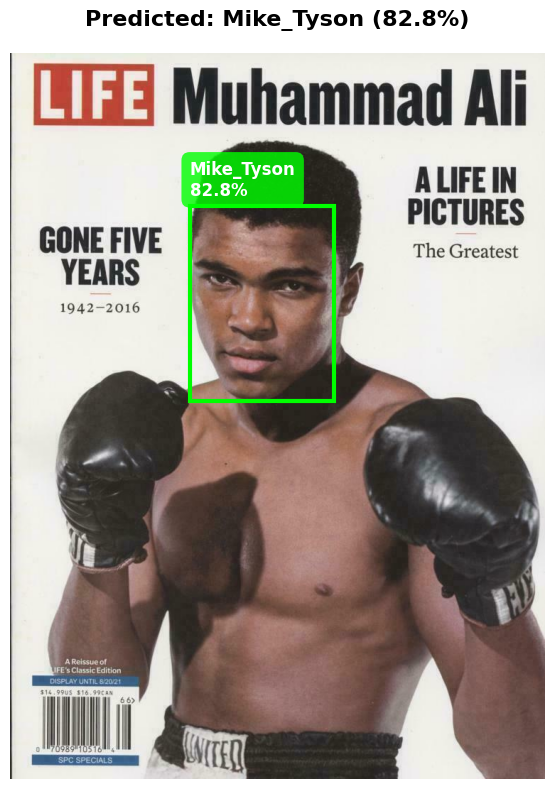


Файл: Tyson_test.jpg
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Mike_Tyson                  78.68%      0.2132
#2    Oscar_De_La_Hoya            69.79%      0.3021
#3    Muhammad_Ali                68.54%      0.3146


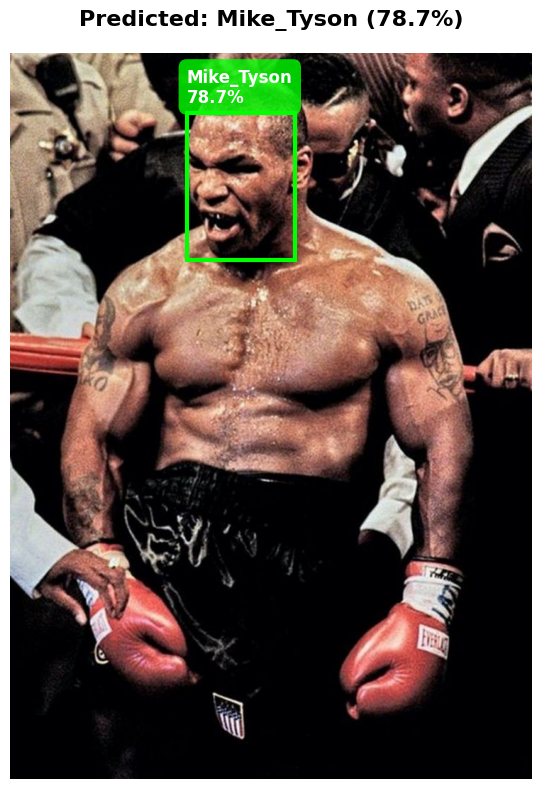


Файл: me_test.jpg
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Me                          84.02%      0.1598
#2    Nestor_Kirchner             74.59%      0.2541
#3    Vicente_Fox                 73.59%      0.2641


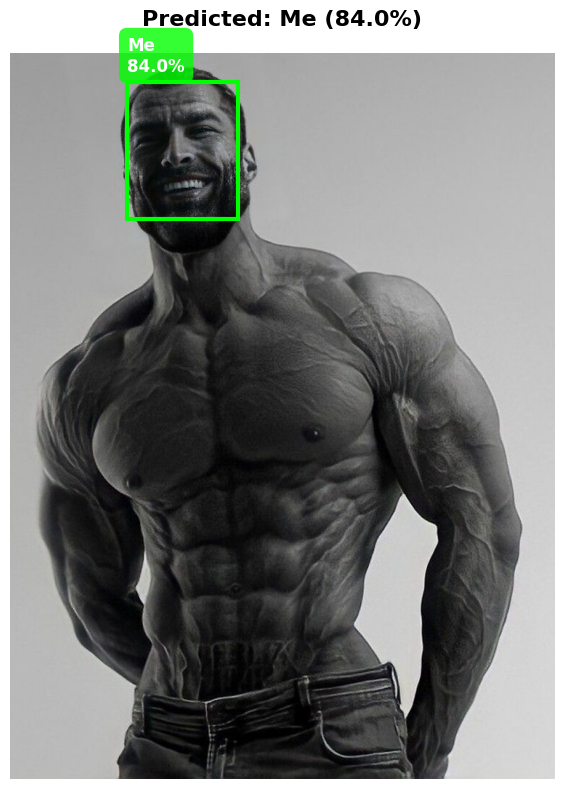

In [ ]:
results = vit_m.recognize([
    "Ali_test.jpg",
    "Tyson_test.jpg",
    "me_test.jpg"
], top_n=3)

Yolov11

In [ ]:
# Вибрати детектор
vit0 = FaceRecognitionViT(
    model_name='vit_base_patch16_224',
    detector='yolov12',  # або 'retinaface', 'scrfd', 'mtcnn', 'yolov11', 'mediapipe', 'opencv'
    device='cuda'
)

# Створити базу даних
vit0.create_database("datasetik_of_mine")

Ініціалізація Vision Transformer (vit_base_patch16_224)...
Використовується: cuda
Ініціалізація детектора: yolov12...
Детектор: YOLOv12m-face
Vision Transformer готовий!

Створення бази даних з datasetik_of_mine


[1/47] Monica_Lewinsky:   0%|          | 0/3 [00:00<?, ?it/s]


0: 640x640 1 face, 44.1ms
Speed: 2.7ms preprocess, 44.1ms inference, 39.8ms postprocess per image at shape (1, 3, 640, 640)


[1/47] Monica_Lewinsky:  33%|███▎      | 1/3 [00:01<00:03,  1.55s/it]


0: 640x640 1 face, 44.1ms
Speed: 2.8ms preprocess, 44.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 44.1ms
Speed: 2.7ms preprocess, 44.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Monica_Lewinsky: 3 embeddings


[2/47] Marie-Josee_Croze:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 44.0ms
Speed: 2.9ms preprocess, 44.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  Marie-Josee_Croze: 1 embeddings


[3/47] Michelle_Lecky:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 27.8ms
Speed: 3.5ms preprocess, 27.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Michelle_Lecky: 1 embeddings


[4/47] Wei_Wu:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 27.8ms
Speed: 3.7ms preprocess, 27.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Wei_Wu: 1 embeddings


[5/47] Martha_Sahagun_de_Fox:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 26.4ms
Speed: 2.9ms preprocess, 26.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Martha_Sahagun_de_Fox: 1 embeddings


[6/47] Ornella_Muti:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 23.5ms
Speed: 2.7ms preprocess, 23.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Ornella_Muti: 1 embeddings


[7/47] Norman_Mineta:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 26.2ms
Speed: 3.2ms preprocess, 26.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Norman_Mineta: 1 embeddings


[8/47] Michael_Killeen:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 24.6ms
Speed: 3.5ms preprocess, 24.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Michael_Killeen: 1 embeddings


[9/47] Pat_Burns:   0%|          | 0/2 [00:00<?, ?it/s]


0: 640x640 1 face, 23.2ms
Speed: 3.1ms preprocess, 23.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.8ms
Speed: 2.6ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  Pat_Burns: 2 embeddings


[10/47] Vanessa_Williams:   0%|          | 0/3 [00:00<?, ?it/s]


0: 640x640 1 face, 29.8ms
Speed: 4.0ms preprocess, 29.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 22.6ms
Speed: 2.8ms preprocess, 22.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[10/47] Vanessa_Williams:  67%|██████▋   | 2/3 [00:00<00:00, 18.10it/s]


0: 640x640 1 face, 25.3ms
Speed: 3.2ms preprocess, 25.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Vanessa_Williams: 3 embeddings


[11/47] Mahathir_Mohamad:   0%|          | 0/14 [00:00<?, ?it/s]


0: 640x640 1 face, 24.5ms
Speed: 3.7ms preprocess, 24.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.1ms
Speed: 3.0ms preprocess, 25.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.8ms
Speed: 2.8ms preprocess, 24.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[11/47] Mahathir_Mohamad:  21%|██▏       | 3/14 [00:00<00:00, 21.04it/s]


0: 640x640 3 faces, 26.6ms
Speed: 3.1ms preprocess, 26.6ms inference, 6.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 23.9ms
Speed: 2.7ms preprocess, 23.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.4ms
Speed: 2.7ms preprocess, 26.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[11/47] Mahathir_Mohamad:  43%|████▎     | 6/14 [00:00<00:00, 20.25it/s]


0: 640x640 1 face, 25.0ms
Speed: 2.3ms preprocess, 25.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.2ms
Speed: 2.9ms preprocess, 25.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[11/47] Mahathir_Mohamad:  64%|██████▍   | 9/14 [00:00<00:00, 20.28it/s]


0: 640x640 1 face, 25.2ms
Speed: 3.5ms preprocess, 25.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 faces, 25.7ms
Speed: 2.9ms preprocess, 25.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 24.8ms
Speed: 2.7ms preprocess, 24.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[11/47] Mahathir_Mohamad:  86%|████████▌ | 12/14 [00:00<00:00, 20.42it/s]


0: 640x640 1 face, 26.7ms
Speed: 2.7ms preprocess, 26.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 25.7ms
Speed: 3.1ms preprocess, 25.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Mahathir_Mohamad: 14 embeddings


[12/47] Mireya_Moscoso:   0%|          | 0/5 [00:00<?, ?it/s]


0: 640x640 1 face, 25.6ms
Speed: 3.6ms preprocess, 25.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.8ms
Speed: 3.4ms preprocess, 24.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.1ms
Speed: 2.9ms preprocess, 25.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[12/47] Mireya_Moscoso:  60%|██████    | 3/5 [00:00<00:00, 20.42it/s]


0: 640x640 1 face, 25.5ms
Speed: 2.2ms preprocess, 25.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.1ms
Speed: 3.6ms preprocess, 24.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Mireya_Moscoso: 5 embeddings


[13/47] Michael_Schumacher:   0%|          | 0/18 [00:00<?, ?it/s]


0: 640x640 2 faces, 23.1ms
Speed: 2.2ms preprocess, 23.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.4ms
Speed: 2.9ms preprocess, 26.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.6ms
Speed: 2.8ms preprocess, 25.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[13/47] Michael_Schumacher:  17%|█▋        | 3/18 [00:00<00:00, 20.83it/s]


0: 640x640 2 faces, 26.6ms
Speed: 2.7ms preprocess, 26.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.1ms
Speed: 3.1ms preprocess, 25.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.5ms
Speed: 2.7ms preprocess, 24.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[13/47] Michael_Schumacher:  33%|███▎      | 6/18 [00:00<00:00, 20.59it/s]


0: 640x640 1 face, 26.3ms
Speed: 2.6ms preprocess, 26.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.5ms
Speed: 2.9ms preprocess, 24.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.4ms
Speed: 2.7ms preprocess, 26.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[13/47] Michael_Schumacher:  50%|█████     | 9/18 [00:00<00:00, 20.38it/s]


0: 640x640 1 face, 25.1ms
Speed: 3.3ms preprocess, 25.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.7ms
Speed: 3.3ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.9ms
Speed: 2.9ms preprocess, 24.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[13/47] Michael_Schumacher:  67%|██████▋   | 12/18 [00:00<00:00, 20.25it/s]


0: 640x640 2 faces, 26.1ms
Speed: 2.3ms preprocess, 26.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.1ms
Speed: 2.9ms preprocess, 26.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.1ms
Speed: 2.7ms preprocess, 25.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[13/47] Michael_Schumacher:  83%|████████▎ | 15/18 [00:00<00:00, 20.38it/s]


0: 640x640 1 face, 26.6ms
Speed: 2.4ms preprocess, 26.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.8ms
Speed: 2.3ms preprocess, 24.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.2ms
Speed: 2.7ms preprocess, 26.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Michael_Schumacher: 18 embeddings


[14/47] Vicente_Fox:   0%|          | 0/32 [00:00<?, ?it/s]


0: 640x640 1 face, 23.7ms
Speed: 4.2ms preprocess, 23.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 26.1ms
Speed: 2.8ms preprocess, 26.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[14/47] Vicente_Fox:   6%|▋         | 2/32 [00:00<00:01, 18.85it/s]


0: 640x640 1 face, 24.6ms
Speed: 2.3ms preprocess, 24.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 25.7ms
Speed: 3.2ms preprocess, 25.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.5ms
Speed: 3.0ms preprocess, 24.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[14/47] Vicente_Fox:  16%|█▌        | 5/32 [00:00<00:01, 20.13it/s]


0: 640x640 1 face, 26.7ms
Speed: 3.4ms preprocess, 26.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.5ms
Speed: 2.9ms preprocess, 25.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.2ms
Speed: 2.6ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[14/47] Vicente_Fox:  25%|██▌       | 8/32 [00:00<00:01, 20.28it/s]


0: 640x640 1 face, 25.6ms
Speed: 3.2ms preprocess, 25.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.8ms
Speed: 2.9ms preprocess, 24.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.8ms
Speed: 3.2ms preprocess, 25.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[14/47] Vicente_Fox:  34%|███▍      | 11/32 [00:00<00:01, 20.13it/s]


0: 640x640 1 face, 24.2ms
Speed: 2.7ms preprocess, 24.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 26.8ms
Speed: 3.1ms preprocess, 26.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.8ms
Speed: 3.2ms preprocess, 24.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[14/47] Vicente_Fox:  44%|████▍     | 14/32 [00:00<00:00, 20.24it/s]


0: 640x640 1 face, 26.1ms
Speed: 3.5ms preprocess, 26.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 faces, 25.2ms
Speed: 2.8ms preprocess, 25.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.9ms
Speed: 2.7ms preprocess, 24.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[14/47] Vicente_Fox:  53%|█████▎    | 17/32 [00:00<00:00, 20.32it/s]


0: 640x640 1 face, 26.2ms
Speed: 2.1ms preprocess, 26.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.1ms
Speed: 3.2ms preprocess, 24.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 faces, 26.2ms
Speed: 3.0ms preprocess, 26.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[14/47] Vicente_Fox:  62%|██████▎   | 20/32 [00:00<00:00, 20.10it/s]


0: 640x640 1 face, 23.6ms
Speed: 2.5ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.8ms
Speed: 3.2ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 faces, 25.5ms
Speed: 2.9ms preprocess, 25.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


[14/47] Vicente_Fox:  72%|███████▏  | 23/32 [00:01<00:00, 20.06it/s]


0: 640x640 1 face, 26.1ms
Speed: 4.5ms preprocess, 26.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.8ms
Speed: 3.7ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.8ms
Speed: 3.2ms preprocess, 25.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[14/47] Vicente_Fox:  81%|████████▏ | 26/32 [00:01<00:00, 20.01it/s]


0: 640x640 1 face, 25.0ms
Speed: 2.4ms preprocess, 25.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.3ms
Speed: 3.0ms preprocess, 26.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.9ms
Speed: 2.8ms preprocess, 25.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[14/47] Vicente_Fox:  91%|█████████ | 29/32 [00:01<00:00, 20.15it/s]


0: 640x640 1 face, 24.6ms
Speed: 3.0ms preprocess, 24.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 25.9ms
Speed: 3.2ms preprocess, 25.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.8ms
Speed: 2.6ms preprocess, 24.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Vicente_Fox: 32 embeddings


[15/47] Mike_Tyson:   0%|          | 0/14 [00:00<?, ?it/s]


0: 640x576 1 face, 60.7ms
Speed: 3.9ms preprocess, 60.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)

0: 384x640 1 face, 119.5ms
Speed: 3.1ms preprocess, 119.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


[15/47] Mike_Tyson:  14%|█▍        | 2/14 [00:00<00:01,  8.19it/s]


0: 352x640 1 face, 55.3ms
Speed: 2.6ms preprocess, 55.3ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)

0: 640x576 1 face, 21.4ms
Speed: 3.4ms preprocess, 21.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 576)


[15/47] Mike_Tyson:  29%|██▊       | 4/14 [00:00<00:00, 10.84it/s]


0: 640x640 2 faces, 25.3ms
Speed: 3.6ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 1 face, 57.5ms
Speed: 2.8ms preprocess, 57.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 544)


[15/47] Mike_Tyson:  43%|████▎     | 6/14 [00:00<00:00, 12.31it/s]


0: 448x640 1 face, 71.6ms
Speed: 2.1ms preprocess, 71.6ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)

0: 640x512 1 face, 56.0ms
Speed: 3.5ms preprocess, 56.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 512)


[15/47] Mike_Tyson:  57%|█████▋    | 8/14 [00:00<00:00, 11.70it/s]


0: 640x480 1 face, 57.1ms
Speed: 1.9ms preprocess, 57.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)

0: 352x640 1 face, 15.3ms
Speed: 2.2ms preprocess, 15.3ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)


[15/47] Mike_Tyson:  71%|███████▏  | 10/14 [00:00<00:00, 12.72it/s]


0: 640x640 2 faces, 23.1ms
Speed: 2.7ms preprocess, 23.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x544 1 face, 22.3ms
Speed: 3.7ms preprocess, 22.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 544)


[15/47] Mike_Tyson:  86%|████████▌ | 12/14 [00:00<00:00, 14.08it/s]


0: 640x640 1 face, 25.4ms
Speed: 3.0ms preprocess, 25.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.2ms
Speed: 2.8ms preprocess, 24.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Mike_Tyson: 14 embeddings


[16/47] Oscar_De_La_Hoya:   0%|          | 0/7 [00:00<?, ?it/s]


0: 640x640 2 faces, 23.7ms
Speed: 3.7ms preprocess, 23.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.8ms
Speed: 3.2ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[16/47] Oscar_De_La_Hoya:  29%|██▊       | 2/7 [00:00<00:00, 19.82it/s]


0: 640x640 1 face, 24.0ms
Speed: 2.6ms preprocess, 24.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 faces, 26.2ms
Speed: 2.7ms preprocess, 26.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.5ms
Speed: 3.1ms preprocess, 24.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[16/47] Oscar_De_La_Hoya:  71%|███████▏  | 5/7 [00:00<00:00, 19.76it/s]


0: 640x640 1 face, 25.7ms
Speed: 2.6ms preprocess, 25.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.3ms
Speed: 3.0ms preprocess, 24.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Oscar_De_La_Hoya: 7 embeddings


[17/47] Mark_Butcher:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 28.0ms
Speed: 3.2ms preprocess, 28.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Mark_Butcher: 1 embeddings


[18/47] Mahmoud_Abbas:   0%|          | 0/29 [00:00<?, ?it/s]


0: 640x640 1 face, 25.2ms
Speed: 3.6ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 24.4ms
Speed: 3.0ms preprocess, 24.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[18/47] Mahmoud_Abbas:   7%|▋         | 2/29 [00:00<00:01, 19.06it/s]


0: 640x640 2 faces, 27.4ms
Speed: 3.2ms preprocess, 27.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.2ms
Speed: 3.5ms preprocess, 24.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[18/47] Mahmoud_Abbas:  14%|█▍        | 4/29 [00:00<00:01, 19.28it/s]


0: 640x640 1 face, 25.9ms
Speed: 3.0ms preprocess, 25.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.9ms
Speed: 3.2ms preprocess, 24.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.7ms
Speed: 3.5ms preprocess, 26.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[18/47] Mahmoud_Abbas:  24%|██▍       | 7/29 [00:00<00:01, 19.57it/s]


0: 640x640 1 face, 24.4ms
Speed: 3.2ms preprocess, 24.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.5ms
Speed: 3.2ms preprocess, 26.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.1ms
Speed: 3.0ms preprocess, 25.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[18/47] Mahmoud_Abbas:  34%|███▍      | 10/29 [00:00<00:00, 19.89it/s]


0: 640x640 1 face, 26.3ms
Speed: 2.7ms preprocess, 26.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 faces, 24.9ms
Speed: 2.8ms preprocess, 24.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 26.2ms
Speed: 3.4ms preprocess, 26.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[18/47] Mahmoud_Abbas:  45%|████▍     | 13/29 [00:00<00:00, 20.02it/s]


0: 640x640 1 face, 25.4ms
Speed: 3.2ms preprocess, 25.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.1ms
Speed: 3.1ms preprocess, 25.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 26.5ms
Speed: 3.0ms preprocess, 26.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[18/47] Mahmoud_Abbas:  55%|█████▌    | 16/29 [00:00<00:00, 20.12it/s]


0: 640x640 1 face, 24.2ms
Speed: 2.8ms preprocess, 24.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 27.0ms
Speed: 3.0ms preprocess, 27.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 23.9ms
Speed: 3.4ms preprocess, 23.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[18/47] Mahmoud_Abbas:  66%|██████▌   | 19/29 [00:00<00:00, 20.02it/s]


0: 640x640 2 faces, 26.3ms
Speed: 2.8ms preprocess, 26.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.8ms
Speed: 3.0ms preprocess, 24.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 27.1ms
Speed: 2.9ms preprocess, 27.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[18/47] Mahmoud_Abbas:  76%|███████▌  | 22/29 [00:01<00:00, 19.97it/s]


0: 640x640 1 face, 24.9ms
Speed: 3.3ms preprocess, 24.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 faces, 23.4ms
Speed: 4.5ms preprocess, 23.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[18/47] Mahmoud_Abbas:  83%|████████▎ | 24/29 [00:01<00:00, 19.48it/s]


0: 640x640 1 face, 26.6ms
Speed: 2.8ms preprocess, 26.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.7ms
Speed: 2.7ms preprocess, 24.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.3ms
Speed: 2.9ms preprocess, 26.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[18/47] Mahmoud_Abbas:  93%|█████████▎| 27/29 [00:01<00:00, 19.67it/s]


0: 640x640 1 face, 25.2ms
Speed: 4.2ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.7ms
Speed: 3.1ms preprocess, 26.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Mahmoud_Abbas: 29 embeddings


[19/47] Yevgeny_Kafelnikov:   0%|          | 0/4 [00:00<?, ?it/s]


0: 640x640 1 face, 24.7ms
Speed: 3.1ms preprocess, 24.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.7ms
Speed: 3.3ms preprocess, 26.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[19/47] Yevgeny_Kafelnikov:  50%|█████     | 2/4 [00:00<00:00, 19.54it/s]


0: 640x640 1 face, 24.3ms
Speed: 4.1ms preprocess, 24.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.8ms
Speed: 3.0ms preprocess, 26.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Yevgeny_Kafelnikov: 4 embeddings


[20/47] Me:   0%|          | 0/5 [00:00<?, ?it/s]


0: 416x640 2 faces, 57.5ms
Speed: 3.0ms preprocess, 57.5ms inference, 1.1ms postprocess per image at shape (1, 3, 416, 640)

0: 640x640 1 face, 23.7ms
Speed: 3.8ms preprocess, 23.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[20/47] Me:  40%|████      | 2/5 [00:00<00:00, 14.39it/s]


0: 448x640 1 face, 17.6ms
Speed: 2.8ms preprocess, 17.6ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 640x576 1 face, 24.4ms
Speed: 3.2ms preprocess, 24.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 576)

0: 544x640 1 face, 59.8ms
Speed: 3.1ms preprocess, 59.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


  Me: 5 embeddings


[21/47] Nestor_Kirchner:   0%|          | 0/37 [00:00<?, ?it/s]


0: 640x640 1 face, 22.8ms
Speed: 2.9ms preprocess, 22.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.1ms
Speed: 3.3ms preprocess, 26.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.8ms
Speed: 3.0ms preprocess, 24.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:   8%|▊         | 3/37 [00:00<00:01, 20.53it/s]


0: 640x640 1 face, 26.8ms
Speed: 3.0ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.6ms
Speed: 3.0ms preprocess, 24.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.0ms
Speed: 3.1ms preprocess, 25.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  16%|█▌        | 6/37 [00:00<00:01, 19.54it/s]


0: 640x640 1 face, 26.5ms
Speed: 3.6ms preprocess, 26.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.1ms
Speed: 2.8ms preprocess, 26.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  22%|██▏       | 8/37 [00:00<00:01, 19.48it/s]


0: 640x640 3 faces, 25.4ms
Speed: 3.1ms preprocess, 25.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.3ms
Speed: 3.0ms preprocess, 25.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.7ms
Speed: 2.8ms preprocess, 25.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  30%|██▉       | 11/37 [00:00<00:01, 19.83it/s]


0: 640x640 1 face, 25.7ms
Speed: 3.9ms preprocess, 25.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.5ms
Speed: 2.5ms preprocess, 24.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  35%|███▌      | 13/37 [00:00<00:01, 19.82it/s]


0: 640x640 1 face, 26.2ms
Speed: 4.6ms preprocess, 26.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.9ms
Speed: 3.2ms preprocess, 24.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  41%|████      | 15/37 [00:00<00:01, 19.69it/s]


0: 640x640 1 face, 26.5ms
Speed: 2.9ms preprocess, 26.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.2ms
Speed: 2.8ms preprocess, 25.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  46%|████▌     | 17/37 [00:00<00:01, 19.69it/s]


0: 640x640 1 face, 26.1ms
Speed: 2.8ms preprocess, 26.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.8ms
Speed: 3.2ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  51%|█████▏    | 19/37 [00:00<00:00, 19.49it/s]


0: 640x640 2 faces, 25.7ms
Speed: 3.2ms preprocess, 25.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.3ms
Speed: 3.1ms preprocess, 26.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  57%|█████▋    | 21/37 [00:01<00:00, 19.55it/s]


0: 640x640 7 faces, 25.3ms
Speed: 3.0ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 faces, 26.3ms
Speed: 3.3ms preprocess, 26.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.1ms
Speed: 2.9ms preprocess, 26.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  65%|██████▍   | 24/37 [00:01<00:00, 19.06it/s]


0: 640x640 1 face, 24.0ms
Speed: 3.9ms preprocess, 24.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 25.9ms
Speed: 3.1ms preprocess, 25.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  70%|███████   | 26/37 [00:01<00:00, 19.28it/s]


0: 640x640 1 face, 24.8ms
Speed: 3.1ms preprocess, 24.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.7ms
Speed: 3.0ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  76%|███████▌  | 28/37 [00:01<00:00, 19.32it/s]


0: 640x640 1 face, 24.2ms
Speed: 3.5ms preprocess, 24.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 faces, 26.7ms
Speed: 2.9ms preprocess, 26.7ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  81%|████████  | 30/37 [00:01<00:00, 19.42it/s]


0: 640x640 1 face, 24.3ms
Speed: 2.8ms preprocess, 24.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 26.1ms
Speed: 2.9ms preprocess, 26.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  86%|████████▋ | 32/37 [00:01<00:00, 19.53it/s]


0: 640x640 1 face, 24.3ms
Speed: 3.4ms preprocess, 24.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 27.4ms
Speed: 3.0ms preprocess, 27.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  92%|█████████▏| 34/37 [00:01<00:00, 18.85it/s]


0: 640x640 1 face, 23.9ms
Speed: 4.1ms preprocess, 23.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.2ms
Speed: 4.5ms preprocess, 24.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[21/47] Nestor_Kirchner:  97%|█████████▋| 36/37 [00:01<00:00, 17.96it/s]


0: 640x640 1 face, 24.8ms
Speed: 3.8ms preprocess, 24.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  Nestor_Kirchner: 37 embeddings


[22/47] Whoopi_Goldberg:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 3 faces, 26.6ms
Speed: 5.8ms preprocess, 26.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


  Whoopi_Goldberg: 1 embeddings


[23/47] Nicole_Kidman:   0%|          | 0/19 [00:00<?, ?it/s]


0: 640x640 2 faces, 22.7ms
Speed: 4.1ms preprocess, 22.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 23.5ms
Speed: 3.0ms preprocess, 23.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[23/47] Nicole_Kidman:  11%|█         | 2/19 [00:00<00:00, 17.88it/s]


0: 640x640 1 face, 23.8ms
Speed: 3.1ms preprocess, 23.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.1ms
Speed: 3.7ms preprocess, 25.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


[23/47] Nicole_Kidman:  21%|██        | 4/19 [00:00<00:00, 17.56it/s]


0: 640x640 1 face, 26.3ms
Speed: 3.3ms preprocess, 26.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 23.8ms
Speed: 3.0ms preprocess, 23.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[23/47] Nicole_Kidman:  32%|███▏      | 6/19 [00:00<00:00, 17.06it/s]


0: 640x640 1 face, 24.3ms
Speed: 3.4ms preprocess, 24.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.5ms
Speed: 3.2ms preprocess, 24.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[23/47] Nicole_Kidman:  42%|████▏     | 8/19 [00:00<00:00, 17.22it/s]


0: 640x640 1 face, 23.7ms
Speed: 3.2ms preprocess, 23.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.0ms
Speed: 3.1ms preprocess, 24.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


[23/47] Nicole_Kidman:  53%|█████▎    | 10/19 [00:00<00:00, 17.12it/s]


0: 640x640 1 face, 23.9ms
Speed: 2.9ms preprocess, 23.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.0ms
Speed: 3.5ms preprocess, 25.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[23/47] Nicole_Kidman:  63%|██████▎   | 12/19 [00:00<00:00, 17.30it/s]


0: 640x640 2 faces, 25.1ms
Speed: 3.5ms preprocess, 25.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.5ms
Speed: 3.8ms preprocess, 24.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[23/47] Nicole_Kidman:  74%|███████▎  | 14/19 [00:00<00:00, 17.10it/s]


0: 640x640 1 face, 24.2ms
Speed: 3.3ms preprocess, 24.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 23.8ms
Speed: 3.3ms preprocess, 23.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


[23/47] Nicole_Kidman:  84%|████████▍ | 16/19 [00:00<00:00, 17.27it/s]


0: 640x640 2 faces, 23.3ms
Speed: 3.6ms preprocess, 23.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 25.0ms
Speed: 3.7ms preprocess, 25.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


[23/47] Nicole_Kidman:  95%|█████████▍| 18/19 [00:01<00:00, 17.24it/s]


0: 640x640 1 face, 24.3ms
Speed: 3.6ms preprocess, 24.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


  Nicole_Kidman: 19 embeddings

[24/47] Muhammad_Ali:   0%|          | 0/17 [00:00<?, ?it/s]


0: 640x640 1 face, 24.4ms
Speed: 3.5ms preprocess, 24.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 24.4ms
Speed: 3.3ms preprocess, 24.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[24/47] Muhammad_Ali:  12%|█▏        | 2/17 [00:00<00:00, 17.47it/s]


0: 640x448 1 face, 85.4ms
Speed: 2.8ms preprocess, 85.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 448)

0: 640x544 1 face, 32.5ms
Speed: 4.2ms preprocess, 32.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 544)


[24/47] Muhammad_Ali:  24%|██▎       | 4/17 [00:00<00:01, 11.97it/s]


0: 640x640 1 face, 26.9ms
Speed: 3.9ms preprocess, 26.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 faces, 30.2ms
Speed: 3.2ms preprocess, 30.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[24/47] Muhammad_Ali:  35%|███▌      | 6/17 [00:00<00:00, 13.27it/s]


0: 640x640 2 faces, 22.8ms
Speed: 3.3ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 23.2ms
Speed: 3.6ms preprocess, 23.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[24/47] Muhammad_Ali:  47%|████▋     | 8/17 [00:00<00:00, 14.38it/s]


0: 640x640 1 face, 23.7ms
Speed: 2.9ms preprocess, 23.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 24.4ms
Speed: 4.2ms preprocess, 24.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


[24/47] Muhammad_Ali:  59%|█████▉    | 10/17 [00:00<00:00, 14.75it/s]


0: 544x640 1 face, 27.6ms
Speed: 3.8ms preprocess, 27.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 576x640 1 face, 91.5ms
Speed: 3.2ms preprocess, 91.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


[24/47] Muhammad_Ali:  71%|███████   | 12/17 [00:00<00:00, 12.62it/s]


0: 640x640 1 face, 27.2ms
Speed: 4.8ms preprocess, 27.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.6ms
Speed: 3.9ms preprocess, 25.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


[24/47] Muhammad_Ali:  82%|████████▏ | 14/17 [00:01<00:00, 13.41it/s]


0: 640x544 1 face, 22.5ms
Speed: 2.6ms preprocess, 22.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 544)

0: 480x640 1 face, 54.0ms
Speed: 3.0ms preprocess, 54.0ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


[24/47] Muhammad_Ali:  94%|█████████▍| 16/17 [00:01<00:00, 14.18it/s]


0: 640x640 2 faces, 23.2ms
Speed: 3.1ms preprocess, 23.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Muhammad_Ali: 17 embeddings


[25/47] Mohamed_Benaissa:   0%|          | 0/2 [00:00<?, ?it/s]


0: 640x640 1 face, 27.0ms
Speed: 3.9ms preprocess, 27.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.9ms
Speed: 2.9ms preprocess, 25.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  Mohamed_Benaissa: 2 embeddings


[26/47] Werner_Schlager:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 25.1ms
Speed: 3.0ms preprocess, 25.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Werner_Schlager: 1 embeddings


[27/47] Patricia_Medina:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 23.2ms
Speed: 3.4ms preprocess, 23.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Patricia_Medina: 1 embeddings


[28/47] Mickey_Rooney:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 7 faces, 24.2ms
Speed: 4.3ms preprocess, 24.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  Mickey_Rooney: 1 embeddings


[29/47] Valery_Giscard_dEstaing:   0%|          | 0/6 [00:00<?, ?it/s]


0: 640x640 1 face, 24.4ms
Speed: 4.0ms preprocess, 24.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.1ms
Speed: 3.2ms preprocess, 26.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[29/47] Valery_Giscard_dEstaing:  33%|███▎      | 2/6 [00:00<00:00, 18.77it/s]


0: 640x640 1 face, 24.1ms
Speed: 3.2ms preprocess, 24.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.3ms
Speed: 3.1ms preprocess, 26.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[29/47] Valery_Giscard_dEstaing:  67%|██████▋   | 4/6 [00:00<00:00, 19.36it/s]


0: 640x640 1 face, 24.9ms
Speed: 3.0ms preprocess, 24.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.5ms
Speed: 3.7ms preprocess, 25.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Valery_Giscard_dEstaing: 6 embeddings


[30/47] Patrice_Chereau:   0%|          | 0/2 [00:00<?, ?it/s]


0: 640x640 2 faces, 25.0ms
Speed: 4.9ms preprocess, 25.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 23.7ms
Speed: 3.5ms preprocess, 23.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Patrice_Chereau: 2 embeddings


[31/47] Mike_Myers:   0%|          | 0/7 [00:00<?, ?it/s]


0: 640x640 1 face, 26.4ms
Speed: 3.1ms preprocess, 26.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 24.8ms
Speed: 3.0ms preprocess, 24.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[31/47] Mike_Myers:  29%|██▊       | 2/7 [00:00<00:00, 19.71it/s]


0: 640x640 1 face, 26.3ms
Speed: 4.2ms preprocess, 26.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.3ms
Speed: 2.9ms preprocess, 26.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[31/47] Mike_Myers:  57%|█████▋    | 4/7 [00:00<00:00, 19.46it/s]


0: 640x640 1 face, 25.3ms
Speed: 3.4ms preprocess, 25.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.8ms
Speed: 4.9ms preprocess, 26.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[31/47] Mike_Myers:  86%|████████▌ | 6/7 [00:00<00:00, 19.16it/s]


0: 640x640 1 face, 24.4ms
Speed: 3.1ms preprocess, 24.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Mike_Myers: 7 embeddings


[32/47] Wang_Nan:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 25.0ms
Speed: 5.0ms preprocess, 25.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


  Wang_Nan: 1 embeddings


[33/47] Tony_Elias:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 22.8ms
Speed: 2.8ms preprocess, 22.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Tony_Elias: 1 embeddings


[34/47] Mel_Brooks:   0%|          | 0/2 [00:00<?, ?it/s]


0: 640x640 1 face, 26.8ms
Speed: 2.9ms preprocess, 26.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 24.8ms
Speed: 3.7ms preprocess, 24.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Mel_Brooks: 2 embeddings


[35/47] Wanda_de_la_Jesus:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 23.8ms
Speed: 3.6ms preprocess, 23.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Wanda_de_la_Jesus: 1 embeddings


[36/47] Vincent_Gallo:   0%|          | 0/3 [00:00<?, ?it/s]


0: 640x640 4 faces, 25.3ms
Speed: 3.5ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.5ms
Speed: 3.0ms preprocess, 26.5ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[36/47] Vincent_Gallo:  67%|██████▋   | 2/3 [00:00<00:00, 19.39it/s]


0: 640x640 1 face, 25.6ms
Speed: 3.4ms preprocess, 25.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Vincent_Gallo: 3 embeddings


[37/47] Michael_Bloomberg:   0%|          | 0/20 [00:00<?, ?it/s]


0: 640x640 2 faces, 25.7ms
Speed: 2.9ms preprocess, 25.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 25.6ms
Speed: 2.9ms preprocess, 25.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[37/47] Michael_Bloomberg:  10%|█         | 2/20 [00:00<00:00, 19.16it/s]


0: 640x640 2 faces, 24.4ms
Speed: 3.1ms preprocess, 24.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.5ms
Speed: 3.7ms preprocess, 26.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[37/47] Michael_Bloomberg:  20%|██        | 4/20 [00:00<00:00, 18.99it/s]


0: 640x640 1 face, 24.4ms
Speed: 3.7ms preprocess, 24.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.6ms
Speed: 2.8ms preprocess, 25.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[37/47] Michael_Bloomberg:  30%|███       | 6/20 [00:00<00:00, 19.15it/s]


0: 640x640 1 face, 25.1ms
Speed: 3.0ms preprocess, 25.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 25.2ms
Speed: 3.0ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[37/47] Michael_Bloomberg:  40%|████      | 8/20 [00:00<00:00, 19.14it/s]


0: 640x640 1 face, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.1ms
Speed: 2.9ms preprocess, 25.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[37/47] Michael_Bloomberg:  50%|█████     | 10/20 [00:00<00:00, 19.23it/s]


0: 640x640 1 face, 26.5ms
Speed: 3.0ms preprocess, 26.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 24.6ms
Speed: 3.7ms preprocess, 24.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[37/47] Michael_Bloomberg:  60%|██████    | 12/20 [00:00<00:00, 18.61it/s]


0: 640x640 1 face, 23.8ms
Speed: 2.9ms preprocess, 23.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 26.6ms
Speed: 3.0ms preprocess, 26.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


[37/47] Michael_Bloomberg:  70%|███████   | 14/20 [00:00<00:00, 18.86it/s]


0: 640x640 1 face, 25.3ms
Speed: 3.4ms preprocess, 25.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.2ms
Speed: 3.2ms preprocess, 25.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[37/47] Michael_Bloomberg:  80%|████████  | 16/20 [00:00<00:00, 18.98it/s]


0: 640x640 1 face, 26.3ms
Speed: 3.1ms preprocess, 26.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.3ms
Speed: 2.9ms preprocess, 24.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


[37/47] Michael_Bloomberg:  90%|█████████ | 18/20 [00:00<00:00, 18.93it/s]


0: 640x640 1 face, 25.5ms
Speed: 3.4ms preprocess, 25.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.7ms
Speed: 3.0ms preprocess, 25.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Michael_Bloomberg: 20 embeddings


[38/47] Yuri_Luzhkov:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 2 faces, 23.6ms
Speed: 4.5ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  Yuri_Luzhkov: 1 embeddings


[39/47] Meryl_Streep:   0%|          | 0/15 [00:00<?, ?it/s]


0: 640x640 1 face, 23.1ms
Speed: 4.3ms preprocess, 23.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.3ms
Speed: 3.0ms preprocess, 25.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[39/47] Meryl_Streep:  13%|█▎        | 2/15 [00:00<00:00, 19.00it/s]


0: 640x640 1 face, 25.3ms
Speed: 3.4ms preprocess, 25.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.6ms
Speed: 3.2ms preprocess, 25.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[39/47] Meryl_Streep:  27%|██▋       | 4/15 [00:00<00:00, 19.09it/s]


0: 640x640 1 face, 26.8ms
Speed: 3.5ms preprocess, 26.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.4ms
Speed: 3.9ms preprocess, 24.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[39/47] Meryl_Streep:  40%|████      | 6/15 [00:00<00:00, 18.98it/s]


0: 640x640 1 face, 25.8ms
Speed: 3.9ms preprocess, 25.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.6ms
Speed: 3.2ms preprocess, 25.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[39/47] Meryl_Streep:  53%|█████▎    | 8/15 [00:00<00:00, 19.06it/s]


0: 640x640 1 face, 25.2ms
Speed: 2.9ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.7ms
Speed: 3.0ms preprocess, 26.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[39/47] Meryl_Streep:  67%|██████▋   | 10/15 [00:00<00:00, 18.92it/s]


0: 640x640 1 face, 31.0ms
Speed: 3.0ms preprocess, 31.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 23.3ms
Speed: 2.8ms preprocess, 23.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[39/47] Meryl_Streep:  80%|████████  | 12/15 [00:00<00:00, 18.73it/s]


0: 640x640 2 faces, 26.4ms
Speed: 3.2ms preprocess, 26.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.9ms
Speed: 2.9ms preprocess, 24.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[39/47] Meryl_Streep:  93%|█████████▎| 14/15 [00:00<00:00, 18.90it/s]


0: 640x640 1 face, 26.6ms
Speed: 3.4ms preprocess, 26.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Meryl_Streep: 15 embeddings


[40/47] Paul_McCartney:   0%|          | 0/7 [00:00<?, ?it/s]


0: 640x640 2 faces, 25.2ms
Speed: 3.1ms preprocess, 25.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 23.8ms
Speed: 2.2ms preprocess, 23.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[40/47] Paul_McCartney:  29%|██▊       | 2/7 [00:00<00:00, 19.38it/s]


0: 640x640 1 face, 26.8ms
Speed: 3.8ms preprocess, 26.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 24.9ms
Speed: 3.2ms preprocess, 24.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[40/47] Paul_McCartney:  57%|█████▋    | 4/7 [00:00<00:00, 19.10it/s]


0: 640x640 1 face, 25.5ms
Speed: 3.6ms preprocess, 25.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 faces, 25.6ms
Speed: 2.9ms preprocess, 25.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[40/47] Paul_McCartney:  86%|████████▌ | 6/7 [00:00<00:00, 19.18it/s]


0: 640x640 2 faces, 25.2ms
Speed: 2.8ms preprocess, 25.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  Paul_McCartney: 7 embeddings


[41/47] Nan_Wang:   0%|          | 0/4 [00:00<?, ?it/s]


0: 640x640 1 face, 26.2ms
Speed: 3.5ms preprocess, 26.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.2ms
Speed: 3.4ms preprocess, 25.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[41/47] Nan_Wang:  50%|█████     | 2/4 [00:00<00:00, 19.00it/s]


0: 640x640 1 face, 25.0ms
Speed: 3.8ms preprocess, 25.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.8ms
Speed: 2.9ms preprocess, 26.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


  Nan_Wang: 4 embeddings


[42/47] Patty_Schnyder:   0%|          | 0/4 [00:00<?, ?it/s]


0: 640x640 1 face, 24.6ms
Speed: 3.2ms preprocess, 24.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.2ms
Speed: 2.9ms preprocess, 25.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


[42/47] Patty_Schnyder:  50%|█████     | 2/4 [00:00<00:00, 19.72it/s]


0: 640x640 1 face, 26.4ms
Speed: 3.7ms preprocess, 26.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.9ms
Speed: 3.5ms preprocess, 24.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  Patty_Schnyder: 4 embeddings


[43/47] Tommy_Franks:   0%|          | 0/16 [00:00<?, ?it/s]


0: 640x640 1 face, 23.7ms
Speed: 3.0ms preprocess, 23.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 faces, 25.5ms
Speed: 2.8ms preprocess, 25.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[43/47] Tommy_Franks:  12%|█▎        | 2/16 [00:00<00:00, 19.79it/s]


0: 640x640 1 face, 26.7ms
Speed: 3.3ms preprocess, 26.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.9ms
Speed: 3.1ms preprocess, 24.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[43/47] Tommy_Franks:  25%|██▌       | 4/16 [00:00<00:00, 19.39it/s]


0: 640x640 2 faces, 26.8ms
Speed: 3.1ms preprocess, 26.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.1ms
Speed: 3.3ms preprocess, 25.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[43/47] Tommy_Franks:  38%|███▊      | 6/16 [00:00<00:00, 19.00it/s]


0: 640x640 1 face, 24.7ms
Speed: 3.5ms preprocess, 24.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 faces, 26.5ms
Speed: 2.8ms preprocess, 26.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[43/47] Tommy_Franks:  50%|█████     | 8/16 [00:00<00:00, 18.93it/s]


0: 640x640 2 faces, 24.6ms
Speed: 3.7ms preprocess, 24.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.0ms
Speed: 2.9ms preprocess, 26.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


[43/47] Tommy_Franks:  62%|██████▎   | 10/16 [00:00<00:00, 18.96it/s]


0: 640x640 1 face, 25.4ms
Speed: 3.1ms preprocess, 25.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 faces, 25.5ms
Speed: 3.0ms preprocess, 25.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[43/47] Tommy_Franks:  75%|███████▌  | 12/16 [00:00<00:00, 19.02it/s]


0: 640x640 1 face, 26.1ms
Speed: 2.9ms preprocess, 26.1ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 24.7ms
Speed: 3.6ms preprocess, 24.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


[43/47] Tommy_Franks:  88%|████████▊ | 14/16 [00:00<00:00, 19.04it/s]


0: 640x640 1 face, 26.2ms
Speed: 3.4ms preprocess, 26.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 25.8ms
Speed: 2.9ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  Tommy_Franks: 16 embeddings


[44/47] Valentina_Cervi:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 23.6ms
Speed: 3.4ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


  Valentina_Cervi: 1 embeddings


[45/47] Miguel_Contreras:   0%|          | 0/2 [00:00<?, ?it/s]


0: 640x640 2 faces, 24.3ms
Speed: 2.8ms preprocess, 24.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 face, 26.6ms
Speed: 2.8ms preprocess, 26.6ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Miguel_Contreras: 2 embeddings


[46/47] Tora_Takagi:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 2 faces, 25.5ms
Speed: 3.3ms preprocess, 25.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


  Tora_Takagi: 1 embeddings


[47/47] Mary_Matalin:   0%|          | 0/1 [00:00<?, ?it/s]


0: 640x640 1 face, 24.1ms
Speed: 4.3ms preprocess, 24.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


  Mary_Matalin: 1 embeddings

База даних створена:
  - Осіб: 47
  - Embeddings: 318
  - Успішно: 318
  - Невдалих: 0



Файл: Ali_test.jpg

0: 640x480 1 face, 33.5ms
Speed: 3.1ms preprocess, 33.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Mike_Tyson                  76.08%      0.2392
#2    Muhammad_Ali                70.08%      0.2992
#3    Michael_Schumacher          55.42%      0.4458


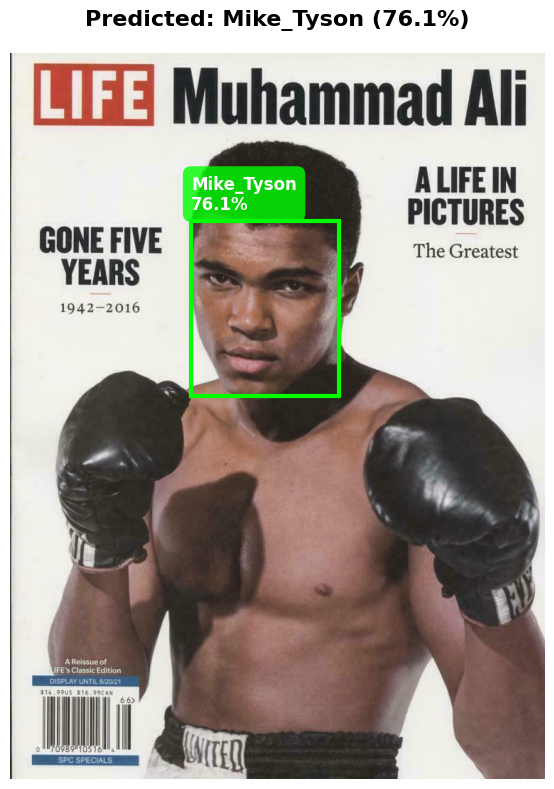


Файл: Tyson_test.jpg

0: 640x480 3 faces, 32.8ms
Speed: 4.0ms preprocess, 32.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Mike_Tyson                  78.25%      0.2175
#2    Oscar_De_La_Hoya            71.63%      0.2837
#3    Muhammad_Ali                69.38%      0.3062


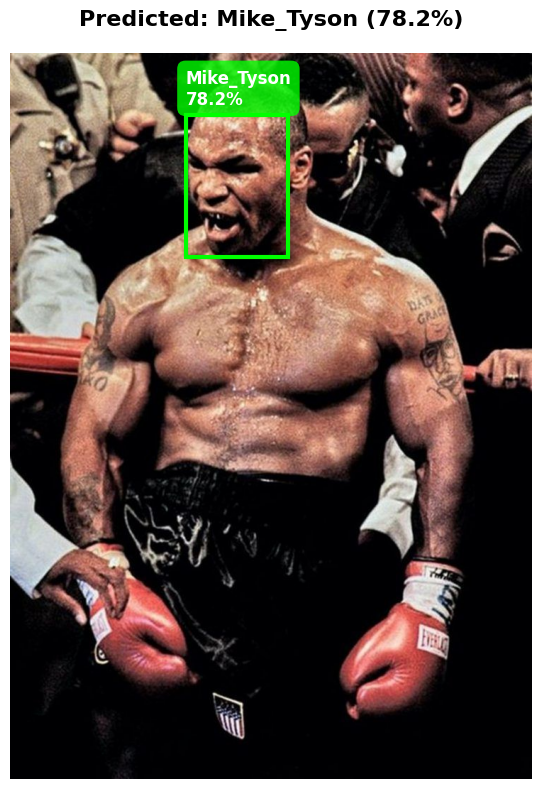


Файл: me_test.jpg

0: 640x480 1 face, 32.8ms
Speed: 3.7ms preprocess, 32.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Me                          66.80%      0.3320
#2    Vicente_Fox                 58.24%      0.4176
#3    Muhammad_Ali                57.72%      0.4228


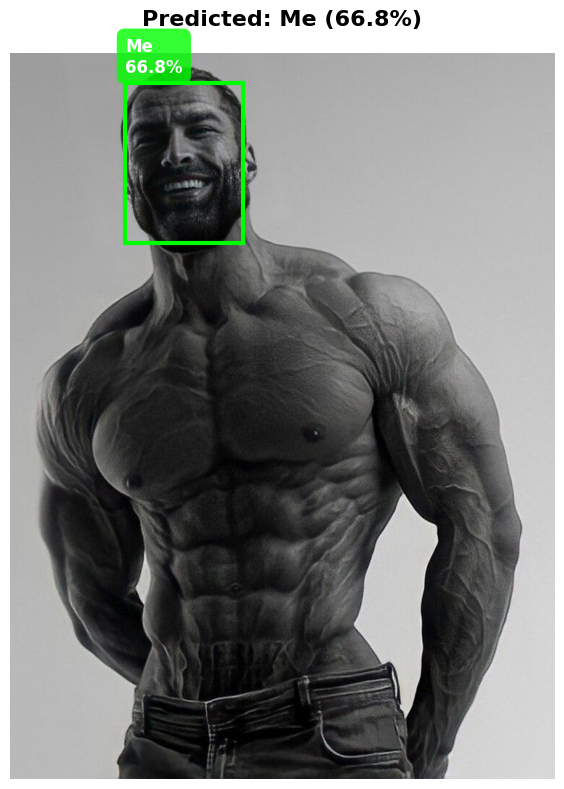

In [ ]:
results = vit0.recognize([
    "Ali_test.jpg",
    "Tyson_test.jpg",
    "me_test.jpg"
], top_n=3)

ssd (3 pics)

In [ ]:
# Вибрати детектор
vit1 = FaceRecognitionViT(
    model_name='vit_base_patch16_224',
    detector='ssd',  # або 'retinaface', 'scrfd', 'mtcnn', 'yolov11', 'mediapipe', 'opencv'
    device='cuda'
)

# Створити базу даних
vit1.create_database("datasetik_of_mine")

Ініціалізація Vision Transformer (vit_base_patch16_224)...
Використовується: cuda
Ініціалізація детектора: ssd...
Завантаження SSD моделі...
Детектор: SSD MobileNet
Vision Transformer готовий!

Створення бази даних з datasetik_of_mine


  Monica_Lewinsky: 3 embeddings


  Marie-Josee_Croze: 1 embeddings


  Michelle_Lecky: 1 embeddings


  Wei_Wu: 1 embeddings


  Martha_Sahagun_de_Fox: 1 embeddings


  Ornella_Muti: 1 embeddings


  Norman_Mineta: 1 embeddings


  Michael_Killeen: 1 embeddings


  Pat_Burns: 2 embeddings


  Vanessa_Williams: 3 embeddings


  Mahathir_Mohamad: 14 embeddings


  Mireya_Moscoso: 5 embeddings


  Michael_Schumacher: 18 embeddings


  Vicente_Fox: 32 embeddings


  Mike_Tyson: 14 embeddings


  Oscar_De_La_Hoya: 7 embeddings


  Mark_Butcher: 1 embeddings


  Mahmoud_Abbas: 29 embeddings


  Yevgeny_Kafelnikov: 4 embeddings


  Me: 5 embeddings


  Nestor_Kirchner: 37 embeddings


  Whoopi_Goldberg: 1 embeddings


  Nicole_Kidman: 19 embeddings


  Muhammad_Ali: 17 embeddings


  Mohamed_Benaissa: 2 embeddings


  Werner_Schlager: 1 embeddings


  Patricia_Medina: 1 embeddings


  Mickey_Rooney: 1 embeddings


  Valery_Giscard_dEstaing: 6 embeddings


  Patrice_Chereau: 2 embeddings


  Mike_Myers: 7 embeddings


  Wang_Nan: 1 embeddings


  Tony_Elias: 1 embeddings


  Mel_Brooks: 2 embeddings


  Wanda_de_la_Jesus: 1 embeddings


  Vincent_Gallo: 3 embeddings


  Michael_Bloomberg: 20 embeddings


  Yuri_Luzhkov: 1 embeddings


  Meryl_Streep: 15 embeddings


  Paul_McCartney: 7 embeddings


  Nan_Wang: 4 embeddings


  Patty_Schnyder: 4 embeddings


  Tommy_Franks: 16 embeddings


  Valentina_Cervi: 1 embeddings


  Miguel_Contreras: 2 embeddings


  Tora_Takagi: 1 embeddings


  Mary_Matalin: 1 embeddings

База даних створена:
  - Осіб: 47
  - Embeddings: 318
  - Успішно: 318
  - Невдалих: 0



Файл: Ali_test.jpg
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Mike_Tyson                  81.77%      0.1823
#2    Muhammad_Ali                70.97%      0.2903
#3    Oscar_De_La_Hoya            57.99%      0.4201


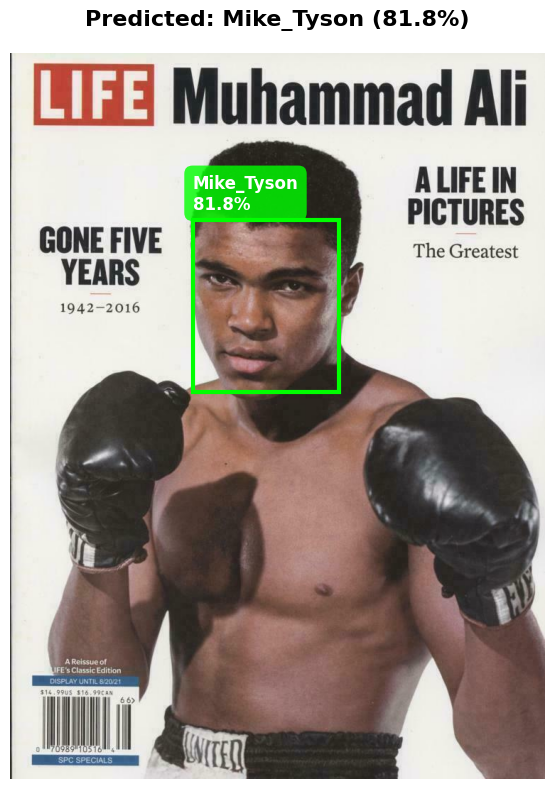


Файл: Tyson_test.jpg
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Oscar_De_La_Hoya            49.47%      0.5053
#2    Mike_Tyson                  48.86%      0.5114
#3    Muhammad_Ali                47.36%      0.5264


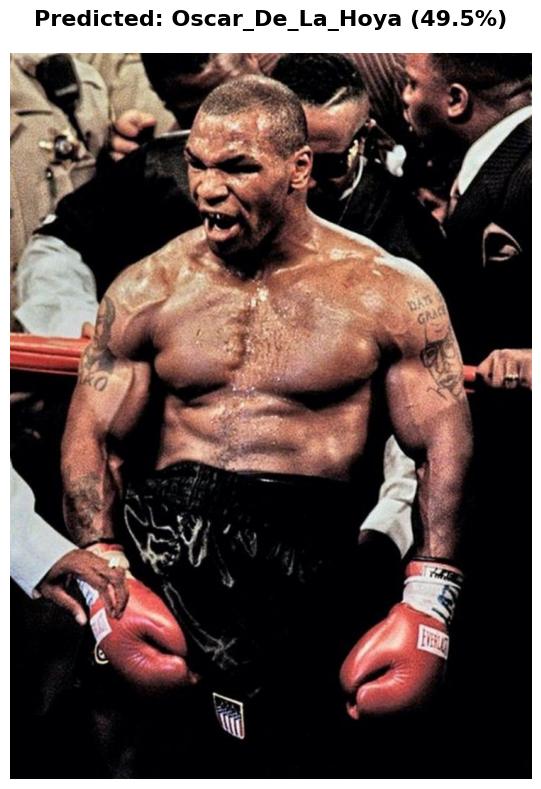


Файл: me_test.jpg
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Me                          82.71%      0.1729
#2    Mike_Tyson                  78.04%      0.2196
#3    Nestor_Kirchner             76.16%      0.2384


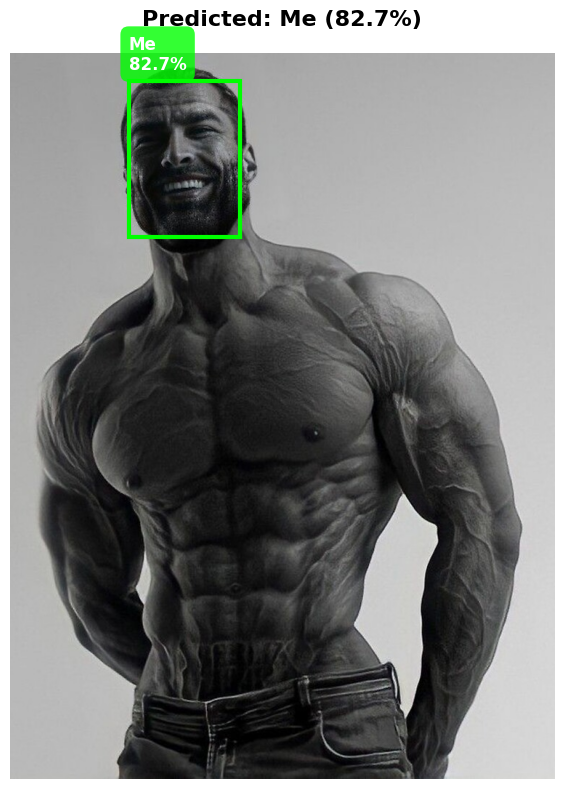

In [ ]:
results = vit1.recognize([
    "Ali_test.jpg",
    "Tyson_test.jpg",
    "me_test.jpg"
], top_n=3)

Retinaface (3 pics)

In [ ]:
# Вибрати детектор
vit2 = FaceRecognitionViT(
    model_name='vit_base_patch16_224',
    detector='retinaface',  # або 'retinaface', 'scrfd', 'mtcnn', 'yolov11', 'mediapipe', 'opencv'
    device='cuda'
)

# Створити базу даних
vit2.create_database("datasetik_of_mine")

Ініціалізація Vision Transformer (vit_base_patch16_224)...
Використовується: cuda
Ініціалізація детектора: retinaface...
Детектор: RetinaFace
Vision Transformer готовий!

Створення бази даних з datasetik_of_mine


[1/47] Monica_Lewinsky:   0%|          | 0/3 [00:00<?, ?it/s]

25-12-14 13:25:51 - Directory /root/.deepface created
25-12-14 13:25:51 - Directory /root/.deepface/weights created
25-12-14 13:25:51 - retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5

  0%|          | 0.00/119M [00:00<?, ?B/s]
  9%|▉         | 11.0M/119M [00:00<00:01, 91.4MB/s]
 22%|██▏       | 26.2M/119M [00:00<00:00, 124MB/s] 
 33%|███▎      | 39.3M/119M [00:00<00:00, 123MB/s]
 45%|████▍     | 53.0M/119M [00:00<00:00, 108MB/s]
 54%|█████▍    | 64.5M/119M [00:00<00:00, 78.8MB/s]
 67%|██████▋   | 79.2M/119M [00:00<00:00, 94.9MB/s]
 76%|███████▌  | 90.2M/119M [00:00<00:00, 93.2MB/s]
 85%|████████▍ | 101M/119M [00:01<00:00, 94.0MB/s] 
100%|██████████| 119M/119M [00:01<00:00, 98.0MB/s]


  Monica_Lewinsky: 3 embeddings


  Marie-Josee_Croze: 1 embeddings


  Michelle_Lecky: 1 embeddings


  Wei_Wu: 1 embeddings


  Martha_Sahagun_de_Fox: 1 embeddings


  Ornella_Muti: 1 embeddings


  Norman_Mineta: 1 embeddings


  Michael_Killeen: 1 embeddings


  Pat_Burns: 2 embeddings


  Vanessa_Williams: 3 embeddings


  Mahathir_Mohamad: 14 embeddings


  Mireya_Moscoso: 5 embeddings


  Michael_Schumacher: 18 embeddings


  Vicente_Fox: 32 embeddings


  Mike_Tyson: 14 embeddings


  Oscar_De_La_Hoya: 7 embeddings


  Mark_Butcher: 1 embeddings


  Mahmoud_Abbas: 29 embeddings


  Yevgeny_Kafelnikov: 4 embeddings


  Me: 5 embeddings


  Nestor_Kirchner: 37 embeddings


  Whoopi_Goldberg: 1 embeddings


  Nicole_Kidman: 19 embeddings


  Muhammad_Ali: 17 embeddings


  Mohamed_Benaissa: 2 embeddings


  Werner_Schlager: 1 embeddings


  Patricia_Medina: 1 embeddings


  Mickey_Rooney: 1 embeddings


  Valery_Giscard_dEstaing: 6 embeddings


  Patrice_Chereau: 2 embeddings


  Mike_Myers: 7 embeddings


  Wang_Nan: 1 embeddings


  Tony_Elias: 1 embeddings


  Mel_Brooks: 2 embeddings


  Wanda_de_la_Jesus: 1 embeddings


  Vincent_Gallo: 3 embeddings


  Michael_Bloomberg: 20 embeddings


  Yuri_Luzhkov: 1 embeddings


  Meryl_Streep: 15 embeddings


  Paul_McCartney: 7 embeddings


  Nan_Wang: 4 embeddings


  Patty_Schnyder: 4 embeddings


  Tommy_Franks: 16 embeddings


  Valentina_Cervi: 1 embeddings


  Miguel_Contreras: 2 embeddings


  Tora_Takagi: 1 embeddings


  Mary_Matalin: 1 embeddings

База даних створена:
  - Осіб: 47
  - Embeddings: 318
  - Успішно: 318
  - Невдалих: 0



Файл: Ali_test.jpg
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Mike_Tyson                  77.53%      0.2247
#2    Muhammad_Ali                67.45%      0.3255
#3    Michael_Schumacher          51.26%      0.4874


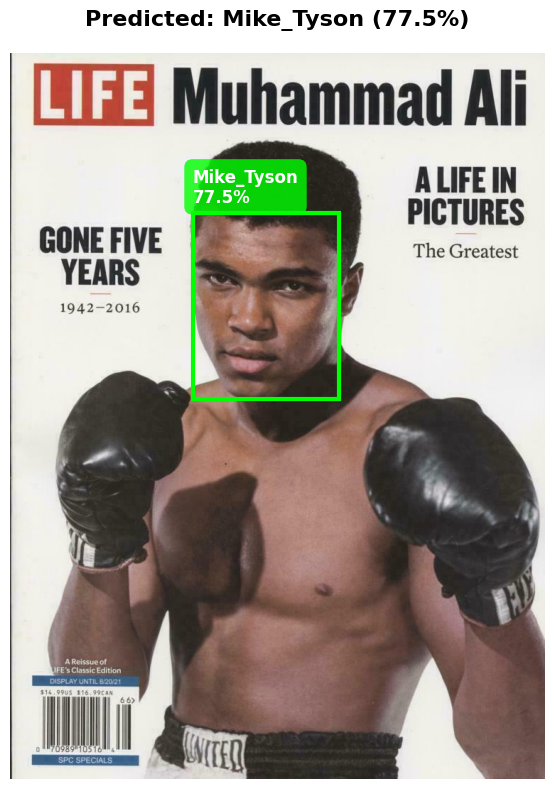


Файл: Tyson_test.jpg
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Mike_Tyson                  79.76%      0.2024
#2    Nestor_Kirchner             69.95%      0.3005
#3    Muhammad_Ali                69.48%      0.3052


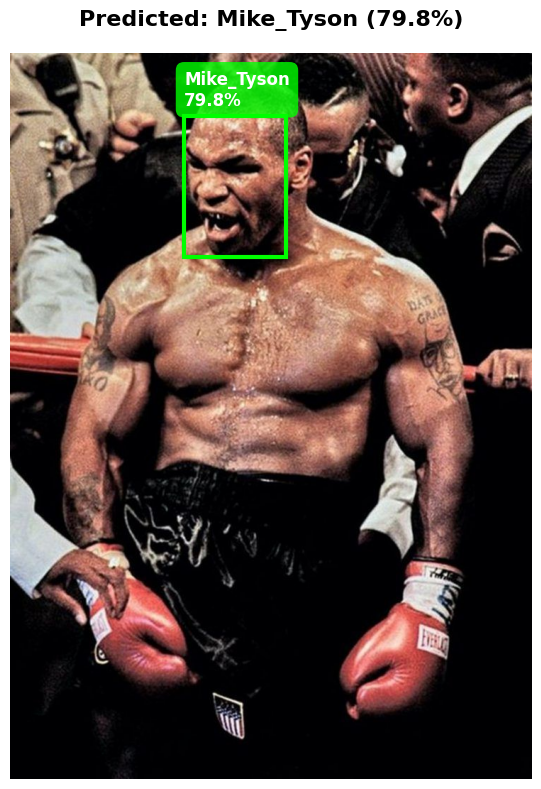


Файл: me_test.jpg
Знайдено обличчя

Топ-3 результатів:
Rank   Name                      Confidence   Distance  
------------------------------------------------------------
#1    Me                          80.60%      0.1940
#2    Nestor_Kirchner             75.68%      0.2432
#3    Mike_Tyson                  75.17%      0.2483


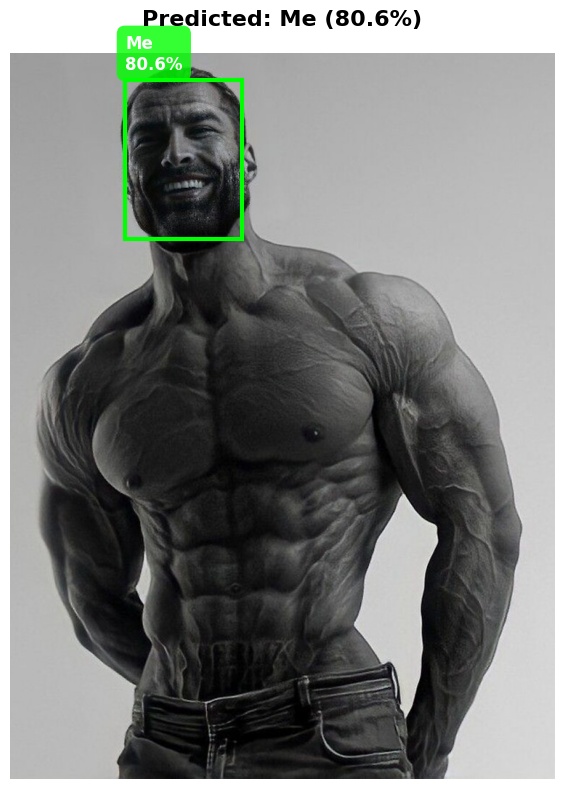

In [ ]:
results = vit2.recognize([
    "Ali_test.jpg",
    "Tyson_test.jpg",
    "me_test.jpg"
], top_n=3)